### When your Language Model cannot even do Determiners right: Probing for Anti-Presuppositions and the Maximize Presupposition! Principle | @BlackboxNLP 2023

- In this notebook, we preprocess the data from Schneider et al. 2019 (available here: https://osf.io/tjp3e) and then use it for masked language modeling for the different conditions as described in the paper. Also we calculate basic statistics for these results (e.g. Completion Sensitivy) and create some plots.

---- 

In [2]:
import pandas as pd
import numpy as np
import torch

from transformers import pipeline

import matplotlib.pyplot as plt

### Data Preprocessing and Conditions

###### UNIQUE FRUIT AND NON-UNIQUE FRUIT CONDITIONS (determiners "the" and "a")

In [2]:
####### GERMAN #######
# load the data 
stimuli_df = pd.read_csv('../data/Schneider2019_stimulus_sentences.csv', header=None)

# only keep the columns that are relevant
columns_to_exclude = [2, 7, 8, 9]

stimuli_df = stimuli_df.drop(columns=columns_to_exclude)

# rename the columns
stimuli_df = stimuli_df.rename(columns={0:"unique_fruit", 1:"double_fruit",
                           3:"determiner", 4:"received_fruit", 
                           5:"stimulus_sentence", 6:"sentence_type",
                           10:"condition", 11:"item"})

# only keep the felicitous and infelicitous conditions (i.e. exclude the false conditions)
stimuli_df = stimuli_df.loc[(stimuli_df['condition'] != 1) & (stimuli_df['condition'] != 2)]

## Replace values in the "double_fruit" column with plural forms (so I can use these to fill the template)
#print(sorted(list(stimuli_df["double_fruit"].value_counts().keys())))
replacements = {
    'Ananas': "Ananasse",
    'Banane': 'Bananen',
    'Birne': 'Birnen',
    'Erdbeere': 'Erdbeeren',
    'Orange': 'Orangen',
    'Pflaume': 'Pflaumen',
    'Zitrone': 'Zitronen'}

stimuli_df['double_fruit'] = stimuli_df['double_fruit'].replace(replacements)

## Exclude the infelicitous conditions from the dataframe
# (because (DEF_infelicitous == INDEF_felicitous and INDEF_infelicitous == DEF_felicitous)
stimuli_df = stimuli_df.loc[~stimuli_df['sentence_type'].isin(["INDEF_infelicitous", "DEF_infelicitous"])]

####### ENGLISH #######
## create an English version of this dataset 
stimuli_df_EN = stimuli_df.copy()

# map old fruit values to new values
fruit_mapping = {
    'Ananas': 'pineapple',
    'Ananasse': 'pineapples',
    'Banane': 'banana',
    'Bananen': 'bananas',
    'Birne': 'pear',
    'Birnen': 'pears',
    'Erdbeere': 'strawberry',
    'Erdbeeren': 'strawberries',
    'Orange': 'orange',
    'Orangen': 'oranges',
    'Pflaume': 'plum',
    'Pflaumen': 'plums',
    'Zitrone': 'lemon', 
    'Zitronen': 'lemons'}

# Replace the values in "unique_fruit" column 
stimuli_df_EN['unique_fruit'] = stimuli_df_EN['unique_fruit'].replace(fruit_mapping)
stimuli_df_EN['received_fruit'] = stimuli_df_EN['received_fruit'].replace(fruit_mapping)
stimuli_df_EN['double_fruit'] = stimuli_df_EN['double_fruit'].replace(fruit_mapping)

### Translate the stimulus_sentence
def cut_sentence(sentence):
    # Split the sentence into words
    words = sentence.split()
    # Remove the first three words and the last word
    words = words[3:-1]
    # Join the remaining words back into a new sentence
    new_sentence = ' '.join(words)
    new_sentence += "."
    return new_sentence

# Function to translate sentences and replace "die" and "eine" with "the" and "a"
def translate_sentence(sentence):
    translated_sentence = sentence
    words = sentence.split()
    for i, word in enumerate(words):
        if word in ['die', 'eine'] and i < len(words) - 1:
            next_word = words[i + 1]
            if next_word in fruit_mapping:
                determiner = 'the' if word == 'die' else 'a'
                translated_sentence = translated_sentence.replace(f"{word} {next_word}", f"Of these, Jan received {determiner} {fruit_mapping[next_word]}")
                translated_sentence = cut_sentence(translated_sentence)
    return translated_sentence

# Apply the translation function to the DataFrame
stimuli_df_EN['stimulus_sentence'] = stimuli_df_EN['stimulus_sentence'].apply(translate_sentence)


####### BOTH LANGUAGES #######
## add column with the filled context sentence to the dataframes
context_template = "Jans Mutter war einkaufen. Sie hat eine {} und zwei {} gekauft." 
context_template_EN = "Jan's mother was shopping. She bought one {} and two {}."

# List to store the filled sentences
filled_sentences = []
filled_sentences_EN = [] 

# Iterate through the DataFrame and fill the placeholders
for index, row in stimuli_df.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context = context_template.format(unique_fruit, double_fruit)
    filled_sentences.append(context)

for index, row in stimuli_df_EN.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context_EN = context_template_EN.format(unique_fruit, double_fruit)
    filled_sentences_EN.append(context_EN)
    
# Now add a new column to the DataFrames with the filled sentences
stimuli_df['context_sentence'] = filled_sentences
stimuli_df_EN['context_sentence'] = filled_sentences_EN

#### create dfs for the different models
df_bert = stimuli_df.copy()
df_bert_multil = stimuli_df.copy()
df_roberta = stimuli_df.copy()

df_bert_EN = stimuli_df_EN.copy()
df_bert_multil_EN = stimuli_df_EN.copy()
df_roberta_EN = stimuli_df_EN.copy()

# dfs for the different fine-tuned models (only for English)
df_bert_EN_finetuned_specific = stimuli_df_EN.copy()
df_bert_multil_EN_finetuned_specific = stimuli_df_EN.copy()
df_roberta_EN_finetuned_specific = stimuli_df_EN.copy()

# add a new column to the dataframe with a MASK token for the determiners
#(--> note: different models may have different mask tokens)
df_bert['masked_sentence'] = df_bert['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
df_bert_multil['masked_sentence'] = df_bert_multil['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
df_roberta['masked_sentence'] = df_roberta['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '<mask>')
# add a new column to the dataframe which contains the whole prompt for the models (i.e. context + masked sentence')
df_bert['prompt'] = df_bert['context_sentence'] + ' ' + df_bert['masked_sentence']
df_bert_multil['prompt'] = df_bert_multil['context_sentence'] + ' ' + df_bert_multil['masked_sentence']
df_roberta['prompt'] = df_roberta['context_sentence'] + ' ' + df_roberta['masked_sentence']

df_bert_EN['masked_sentence'] = df_bert_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_bert_multil_EN['masked_sentence'] = df_bert_multil_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_roberta_EN['masked_sentence'] = df_roberta_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_bert_EN['prompt'] = df_bert_EN['context_sentence'] + ' ' + df_bert_EN['masked_sentence']
df_bert_multil_EN['prompt'] = df_bert_multil_EN['context_sentence'] + ' ' + df_bert_multil_EN['masked_sentence']
df_roberta_EN['prompt'] = df_roberta_EN['context_sentence'] + ' ' + df_roberta_EN['masked_sentence']

df_bert_EN_finetuned_specific['masked_sentence'] = df_bert_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_bert_multil_EN_finetuned_specific['masked_sentence'] = df_bert_multil_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_roberta_EN_finetuned_specific['masked_sentence'] = df_roberta_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_bert_EN_finetuned_specific['prompt'] = df_bert_EN_finetuned_specific['context_sentence'] + ' ' + df_bert_EN_finetuned_specific['masked_sentence']
df_bert_multil_EN_finetuned_specific['prompt'] = df_bert_multil_EN_finetuned_specific['context_sentence'] + ' ' + df_bert_multil_EN_finetuned_specific['masked_sentence']
df_roberta_EN_finetuned_specific['prompt'] = df_roberta_EN_finetuned_specific['context_sentence'] + ' ' + df_roberta_EN_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_bert['model_name'] = "bert-base-german-cased"
df_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_roberta['model_name'] ="xlm-roberta-base"
df_bert_EN['model_name'] = "bert-base-cased"
df_bert_multil_EN['model_name'] ="bert-base-multilingual-cased"
df_roberta_EN['model_name'] ="xlm-roberta-base"
df_bert_EN_finetuned_specific['model_name'] = "bert-base-cased -- finetuned specific masking"
df_bert_multil_EN_finetuned_specific['model_name'] ="bert-base-multilingual-cased finetuned specific masking"
df_roberta_EN_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"


/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3232936567.py:132: FutureWarning: The default value of regex will change from True to False in a future version.
  df_bert['masked_sentence'] = df_bert['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3232936567.py:133: FutureWarning: The default value of regex will change from True to False in a future version.
  df_bert_multil['masked_sentence'] = df_bert_multil['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3232936567.py:134: FutureWarning: The default value of regex will change from True to False in a future version.
  df_roberta['masked_sentence'] = df_roberta['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '<mask>')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3232936567.py:140: FutureWarning: The default value of regex will change from 

###### PAIR OF FRUITS CONDITION (triggers "both" and "all")

In [3]:
####### GERMAN #######
### create a new dataframe to test the alle/beide condition (not from Schneider, but my extension)
stimuli_df_allebeide = stimuli_df.copy()

# only keep the INDEF condition because it is the easiest one to change
stimuli_df_allebeide = stimuli_df_allebeide.loc[~stimuli_df_allebeide['sentence_type'].isin(["DEF_felicitous"])]

# function to replace the singular fruit names with the plural form and the determiner with "beide"
def replace_fruit_names(sentence, double_fruit):
    # Extract the singular fruit name from the sentence
    singular_fruit = sentence.split(" ")[-2]  # because the singular fruit name is always the second last word

    # Replace the singular fruit name with the plural form from "double_fruit" column
    plural_fruit = double_fruit if double_fruit else singular_fruit + "en"
    new_sentence = sentence.replace(singular_fruit, plural_fruit)
    
    # Replace "eine" with "beide"
    new_sentence = new_sentence.replace("eine", "beide")
    return new_sentence

# Apply the function to the "sentence_type" column 
stimuli_df_allebeide['stimulus_sentence'] = stimuli_df_allebeide.apply(lambda row: replace_fruit_names(row['stimulus_sentence'], row['double_fruit']), axis=1)

# Replace column name "determiner" with "trigger"
stimuli_df_allebeide.rename(columns={'determiner': 'trigger'}, inplace=True)

# Replace values in "sentence_type" column
stimuli_df_allebeide['sentence_type'] = stimuli_df_allebeide['sentence_type'].replace('INDEF_felicitous', 'all_both')

# Replace values in "trigger" column
stimuli_df_allebeide['trigger'] = stimuli_df_allebeide['trigger'].replace('INDEF', 'beide')


####### ENGLISH #######
### create a new dataframe to test all/both for the English data too
stimuli_df_allboth = stimuli_df_EN.copy()

# only keep the INDEF condition because it is the easiest one to change
stimuli_df_allboth = stimuli_df_allboth.loc[~stimuli_df_allboth['sentence_type'].isin(["DEF_felicitous"])]

def replace_with_plural(sentence, double_fruit):
    # Extract the singular fruit name from the sentence
    singular_fruit = sentence.split()[-2].lower()  # Assuming the singular fruit name is always the second last word
    
    # Replace the singular fruit name with the plural form from "double_fruit" column
    plural_fruit = double_fruit if double_fruit else singular_fruit + "s"
    
    # Replace only the exact occurrence of the singular fruit name with the plural form in the sentence
    new_sentence = sentence.replace(' ' + singular_fruit + ' ', ' both ' + plural_fruit + ' ')
    # work around because replacing didn't work
    new_sentence = " ".join(new_sentence.split()[0:-1])+ "."
    
    return new_sentence

# Apply the function to the "stimulus_sentence" column
stimuli_df_allboth['stimulus_sentence'] = stimuli_df_allboth.apply(lambda row: replace_with_plural(row['stimulus_sentence'], row['double_fruit']), axis=1)

# Replace column name "determiner" with "trigger"
stimuli_df_allboth.rename(columns={'determiner': 'trigger'}, inplace=True)

# Replace values in "sentence_type" column
stimuli_df_allboth['sentence_type'] = stimuli_df_allboth['sentence_type'].replace('INDEF_felicitous', 'all_both')

# Replace values in "trigger" column
stimuli_df_allboth['trigger'] = stimuli_df_allboth['trigger'].replace('INDEF', 'both')

#### create dfs for the different models
df_allebeide_bert = stimuli_df_allebeide.copy()
df_allebeide_bert_multil = stimuli_df_allebeide.copy()
df_allebeide_roberta = stimuli_df_allebeide.copy()

df_allboth_bert = stimuli_df_allboth.copy()
df_allboth_bert_multil = stimuli_df_allboth.copy()
df_allboth_roberta = stimuli_df_allboth.copy()

# dfs for the different fine-tuned models (only for English)
df_allboth_bert_finetuned_specific = stimuli_df_allboth.copy()
df_allboth_bert_multil_finetuned_specific = stimuli_df_allboth.copy()
df_allboth_roberta_finetuned_specific = stimuli_df_allboth.copy()

# add a new column to the dataframe with a MASK token for the determiners
df_allebeide_bert['masked_sentence'] = df_allebeide_bert['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
df_allebeide_bert_multil['masked_sentence'] = df_allebeide_bert_multil['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
df_allebeide_roberta['masked_sentence'] = df_allebeide_roberta['stimulus_sentence'].str.replace(r'\bbeide\b', '<mask>')
df_allebeide_bert['prompt'] = df_allebeide_bert['context_sentence'] + ' ' + df_allebeide_bert['masked_sentence']
df_allebeide_bert_multil['prompt'] = df_allebeide_bert_multil['context_sentence'] + ' ' + df_allebeide_bert_multil['masked_sentence']
df_allebeide_roberta['prompt'] = df_allebeide_roberta['context_sentence'] + ' ' + df_allebeide_roberta['masked_sentence']

df_allboth_bert['masked_sentence'] = df_allboth_bert['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_bert_multil['masked_sentence'] = df_allboth_bert_multil['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_roberta['masked_sentence'] = df_allboth_roberta['stimulus_sentence'].str.replace(r'\bboth\b', '<mask>')
df_allboth_bert['prompt'] = df_allboth_bert['context_sentence'] + ' ' + df_allboth_bert['masked_sentence']
df_allboth_bert_multil['prompt'] = df_allboth_bert_multil['context_sentence'] + ' ' + df_allboth_bert_multil['masked_sentence']
df_allboth_roberta['prompt'] = df_allboth_roberta['context_sentence'] + ' ' + df_allboth_roberta['masked_sentence']

df_allboth_bert_finetuned_specific['masked_sentence'] = df_allboth_bert_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_bert_multil_finetuned_specific['masked_sentence'] = df_allboth_bert_multil_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_roberta_finetuned_specific['masked_sentence'] = df_allboth_roberta_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '<mask>')
df_allboth_bert_finetuned_specific['prompt'] = df_allboth_bert_finetuned_specific['context_sentence'] + ' ' + df_allboth_bert_finetuned_specific['masked_sentence']
df_allboth_bert_multil_finetuned_specific['prompt'] = df_allboth_bert_multil_finetuned_specific['context_sentence'] + ' ' + df_allboth_bert_multil_finetuned_specific['masked_sentence']
df_allboth_roberta_finetuned_specific['prompt'] = df_allboth_roberta_finetuned_specific['context_sentence'] + ' ' + df_allboth_roberta_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_allebeide_bert['model_name'] = "bert-base-german-cased"
df_allebeide_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_allebeide_roberta['model_name'] ="xlm-roberta-base"
df_allboth_bert['model_name'] = "bert-base-cased"
df_allboth_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_allboth_roberta['model_name'] ="xlm-roberta-base"
df_allboth_bert_finetuned_specific['model_name'] = "bert-base-cased -- finetuned specific masking"
df_allboth_bert_multil_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_allboth_roberta_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"

/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3977963494.py:82: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_bert['masked_sentence'] = df_allebeide_bert['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3977963494.py:83: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_bert_multil['masked_sentence'] = df_allebeide_bert_multil['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3977963494.py:84: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_roberta['masked_sentence'] = df_allebeide_roberta['stimulus_sentence'].str.replace(r'\bbeide\b', '<mask>')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3977963494.py:89: FutureWarning: The


###### ADDITIONAL CONDITIONS 

###### Definite determiner in the context sentence

In [4]:
### make a copy of the df
stimuli_df_defdet = stimuli_df.copy()
stimuli_df_defdet_EN = stimuli_df_EN.copy()

#change context sentence to def-det in pre context
context_template_defdet_EN = "Jan's mother was shopping. She bought the {} and two {}." 
context_template_defdet = "Jans Mutter war einkaufen. Sie hat die {} und zwei {} gekauft." 

#List to store the filled sentences
filled_sentences_defdet = []
filled_sentences_defdet_EN = []

# Iterate through the DataFrame and fill the placeholders
for index, row in stimuli_df_defdet.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context_defdet = context_template_defdet.format(unique_fruit, double_fruit)
    filled_sentences_defdet.append(context_defdet)
    
for index, row in stimuli_df_defdet_EN.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context_defdet_EN = context_template_defdet_EN.format(unique_fruit, double_fruit)
    filled_sentences_defdet_EN.append(context_defdet_EN)
    
# Now add a new column to the DataFrames with the filled sentences
stimuli_df_defdet['context_sentence'] = filled_sentences_defdet
stimuli_df_defdet_EN['context_sentence'] = filled_sentences_defdet_EN

#### create dfs for the different models
df_defdet_bert = stimuli_df_defdet.copy()
df_defdet_bert_multil = stimuli_df_defdet.copy()
df_defdet_roberta = stimuli_df_defdet.copy()

df_defdet_bert_EN = stimuli_df_defdet_EN.copy()
df_defdet_bert_multil_EN = stimuli_df_defdet_EN.copy()
df_defdet_roberta_EN = stimuli_df_defdet_EN.copy()

# dfs for the different fine-tuned models (only for English)
df_defdet_bert_EN_finetuned_specific = stimuli_df_defdet_EN.copy()
df_defdet_bert_multil_EN_finetuned_specific = stimuli_df_defdet_EN.copy()
df_defdet_roberta_EN_finetuned_specific = stimuli_df_defdet_EN.copy()

# add a new column to the dataframe with a MASK token for the determiners
df_defdet_bert['masked_sentence'] = df_defdet_bert['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
df_defdet_bert_multil['masked_sentence'] = df_defdet_bert_multil['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
df_defdet_roberta['masked_sentence'] = df_defdet_roberta['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '<mask>')
df_defdet_bert['prompt'] = df_defdet_bert['context_sentence'] + ' ' + df_defdet_bert['masked_sentence']
df_defdet_bert_multil['prompt'] = df_defdet_bert_multil['context_sentence'] + ' ' + df_defdet_bert_multil['masked_sentence']
df_defdet_roberta['prompt'] = df_defdet_roberta['context_sentence'] + ' ' + df_defdet_roberta['masked_sentence']

df_defdet_bert_EN['masked_sentence'] = df_defdet_bert_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_defdet_bert_multil_EN['masked_sentence'] = df_defdet_bert_multil_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_defdet_roberta_EN['masked_sentence'] = df_defdet_roberta_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_defdet_bert_EN['prompt'] = df_defdet_bert_EN['context_sentence'] + ' ' + df_defdet_bert_EN['masked_sentence']
df_defdet_bert_multil_EN['prompt'] = df_defdet_bert_multil_EN['context_sentence'] + ' ' + df_defdet_bert_multil_EN['masked_sentence']
df_defdet_roberta_EN['prompt'] = df_defdet_roberta_EN['context_sentence'] + ' ' + df_defdet_roberta_EN['masked_sentence']

df_defdet_bert_EN_finetuned_specific['masked_sentence'] = df_defdet_bert_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_defdet_bert_multil_EN_finetuned_specific['masked_sentence'] = df_defdet_bert_multil_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_defdet_roberta_EN_finetuned_specific['masked_sentence'] = df_defdet_roberta_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_defdet_bert_EN_finetuned_specific['prompt'] = df_defdet_bert_EN_finetuned_specific['context_sentence'] + ' ' + df_defdet_bert_EN_finetuned_specific['masked_sentence']
df_defdet_bert_multil_EN_finetuned_specific['prompt'] = df_defdet_bert_multil_EN_finetuned_specific['context_sentence'] + ' ' + df_defdet_bert_multil_EN_finetuned_specific['masked_sentence']
df_defdet_roberta_EN_finetuned_specific['prompt'] = df_defdet_roberta_EN_finetuned_specific['context_sentence'] + ' ' + df_defdet_roberta_EN_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_defdet_bert['model_name'] = "bert-base-german-cased"
df_defdet_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_defdet_roberta['model_name'] ="xlm-roberta-base"
df_defdet_bert_EN['model_name'] = "bert-base-german-cased"
df_defdet_bert_multil_EN['model_name'] ="bert-base-multilingual-cased"
df_defdet_roberta_EN['model_name'] ="xlm-roberta-base"
df_defdet_bert_EN_finetuned_specific['model_name'] = "bert-base-german-cased -- finetuned specific masking"
df_defdet_bert_multil_EN_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_defdet_roberta_EN_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"



/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/4099437934.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df_defdet_bert['masked_sentence'] = df_defdet_bert['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/4099437934.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  df_defdet_bert_multil['masked_sentence'] = df_defdet_bert_multil['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/4099437934.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
  df_defdet_roberta['masked_sentence'] = df_defdet_roberta['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '<mask>')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/4099437934.py:52: FutureWarning: The de

###### Indefinite determiner in the context sentence for English

In [5]:
### make a copy of the df
stimuli_df_indefdet_EN = stimuli_df_EN.copy()

#change context sentence to indef-det in pre context
context_template_indefdet_EN = "Jan's mother was shopping. She bought a {} and two {}." 

#List to store the filled sentences
filled_sentences_indefdet_EN = []

# Iterate through the DataFrame and fill the placeholders
for index, row in stimuli_df_indefdet_EN.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context_indefdet_EN = context_template_indefdet_EN.format(unique_fruit, double_fruit)
    filled_sentences_indefdet_EN.append(context_indefdet_EN)
    
# Now add a new column to the DataFrames with the filled sentences
stimuli_df_indefdet_EN['context_sentence'] = filled_sentences_indefdet_EN

#### create dfs for the different models
df_indefdet_bert_EN = stimuli_df_indefdet_EN.copy()
df_indefdet_bert_multil_EN = stimuli_df_indefdet_EN.copy()
df_indefdet_roberta_EN = stimuli_df_indefdet_EN.copy()

# dfs for the different fine-tuned model
df_indefdet_bert_EN_finetuned_specific = stimuli_df_indefdet_EN.copy()
df_indefdet_bert_multil_EN_finetuned_specific = stimuli_df_indefdet_EN.copy()
df_indefdet_roberta_EN_finetuned_specific = stimuli_df_indefdet_EN.copy()

# add a new column to the dataframe with a MASK token for the determiners
df_indefdet_bert_EN['masked_sentence'] = df_indefdet_bert_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_indefdet_bert_multil_EN['masked_sentence'] = df_indefdet_bert_multil_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_indefdet_roberta_EN['masked_sentence'] = df_indefdet_roberta_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_indefdet_bert_EN['prompt'] = df_indefdet_bert_EN['context_sentence'] + ' ' + df_indefdet_bert_EN['masked_sentence']
df_indefdet_bert_multil_EN['prompt'] = df_indefdet_bert_multil_EN['context_sentence'] + ' ' + df_indefdet_bert_multil_EN['masked_sentence']
df_indefdet_roberta_EN['prompt'] = df_indefdet_roberta_EN['context_sentence'] + ' ' + df_indefdet_roberta_EN['masked_sentence']

df_indefdet_bert_EN_finetuned_specific['masked_sentence'] = df_indefdet_bert_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_indefdet_bert_multil_EN_finetuned_specific['masked_sentence'] = df_indefdet_bert_multil_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_indefdet_roberta_EN_finetuned_specific['masked_sentence'] = df_indefdet_roberta_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_indefdet_bert_EN_finetuned_specific['prompt'] = df_indefdet_bert_EN_finetuned_specific['context_sentence'] + ' ' + df_indefdet_bert_EN_finetuned_specific['masked_sentence']
df_indefdet_bert_multil_EN_finetuned_specific['prompt'] = df_indefdet_bert_multil_EN_finetuned_specific['context_sentence'] + ' ' + df_indefdet_bert_multil_EN_finetuned_specific['masked_sentence']
df_indefdet_roberta_EN_finetuned_specific['prompt'] = df_indefdet_roberta_EN_finetuned_specific['context_sentence'] + ' ' + df_indefdet_roberta_EN_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_indefdet_bert_EN['model_name'] = "bert-base-german-cased"
df_indefdet_bert_multil_EN['model_name'] ="bert-base-multilingual-cased"
df_indefdet_roberta_EN['model_name'] ="xlm-roberta-base"
df_indefdet_bert_EN_finetuned_specific['model_name'] = "bert-base-german-cased -- finetuned specific masking"
df_indefdet_bert_multil_EN_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_indefdet_roberta_EN_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"


/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3652158259.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df_indefdet_bert_EN['masked_sentence'] = df_indefdet_bert_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3652158259.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df_indefdet_bert_multil_EN['masked_sentence'] = df_indefdet_bert_multil_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3652158259.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_indefdet_roberta_EN['masked_sentence'] = df_indefdet_roberta_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3652158259.py:38: 

###### "both" in the context sentence.

In [6]:
### make a copy of the df
stimuli_df_allebeide_beidepre = stimuli_df_allebeide.copy()
stimuli_df_allboth_bothpre = stimuli_df_allboth.copy()

# Replace "zwei" with "beide" in the "context_sentence" column
stimuli_df_allebeide_beidepre['context_sentence'] = stimuli_df_allebeide_beidepre['context_sentence'].replace('zwei', 'beide', regex=True)
# Replace "two" with "both" in the "context_sentence" column of the English data
stimuli_df_allboth_bothpre['context_sentence'] = stimuli_df_allboth_bothpre['context_sentence'].replace('two', 'both', regex=True)

#### create dfs for the different models
df_allebeide_beidepre_bert = stimuli_df_allebeide_beidepre.copy()
df_allebeide_beidepre_bert_multil = stimuli_df_allebeide_beidepre.copy()
df_allebeide_beidepre_roberta = stimuli_df_allebeide_beidepre.copy()
 
df_allboth_bothpre_bert = stimuli_df_allboth_bothpre.copy()
df_allboth_bothpre_bert_multil = stimuli_df_allboth_bothpre.copy()
df_allboth_bothpre_roberta = stimuli_df_allboth_bothpre.copy()

# dfs for the different fine-tuned models (only for English)
df_allboth_bothpre_bert_finetuned_specific = stimuli_df_allboth_bothpre.copy()
df_allboth_bothpre_bert_multil_finetuned_specific = stimuli_df_allboth_bothpre.copy()
df_allboth_bothpre_roberta_finetuned_specific = stimuli_df_allboth_bothpre.copy()

# add a new column to the dataframe with a MASK token for the determiners
df_allebeide_beidepre_bert['masked_sentence'] = df_allebeide_beidepre_bert['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
df_allebeide_beidepre_bert_multil['masked_sentence'] = df_allebeide_beidepre_bert_multil['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
df_allebeide_beidepre_roberta['masked_sentence'] = df_allebeide_beidepre_roberta['stimulus_sentence'].str.replace(r'\bbeide\b', '<mask>')
df_allebeide_beidepre_bert['prompt'] = df_allebeide_beidepre_bert['context_sentence'] + ' ' + df_allebeide_beidepre_bert['masked_sentence']
df_allebeide_beidepre_bert_multil['prompt'] = df_allebeide_beidepre_bert_multil['context_sentence'] + ' ' + df_allebeide_beidepre_bert_multil['masked_sentence']
df_allebeide_beidepre_roberta['prompt'] = df_allebeide_beidepre_roberta['context_sentence'] + ' ' + df_allebeide_beidepre_roberta['masked_sentence']

df_allboth_bothpre_bert['masked_sentence'] = df_allboth_bothpre_bert['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_bothpre_bert_multil['masked_sentence'] = df_allboth_bothpre_bert_multil['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_bothpre_roberta['masked_sentence'] = df_allboth_bothpre_roberta['stimulus_sentence'].str.replace(r'\bboth\b', '<mask>')
df_allboth_bothpre_bert['prompt'] = df_allboth_bothpre_bert['context_sentence'] + ' ' + df_allboth_bothpre_bert['masked_sentence']
df_allboth_bothpre_bert_multil['prompt'] = df_allboth_bothpre_bert_multil['context_sentence'] + ' ' + df_allboth_bothpre_bert_multil['masked_sentence']
df_allboth_bothpre_roberta['prompt'] = df_allboth_bothpre_roberta['context_sentence'] + ' ' + df_allboth_bothpre_roberta['masked_sentence']

df_allboth_bothpre_bert_finetuned_specific['masked_sentence'] = df_allboth_bothpre_bert_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_bothpre_bert_multil_finetuned_specific['masked_sentence'] = df_allboth_bothpre_bert_multil_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_bothpre_roberta_finetuned_specific['masked_sentence'] = df_allboth_bothpre_roberta_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '<mask>')
df_allboth_bothpre_bert_finetuned_specific['prompt'] = df_allboth_bothpre_bert_finetuned_specific['context_sentence'] + ' ' + df_allboth_bothpre_bert_finetuned_specific['masked_sentence']
df_allboth_bothpre_bert_multil_finetuned_specific['prompt'] = df_allboth_bothpre_bert_multil_finetuned_specific['context_sentence'] + ' ' + df_allboth_bothpre_bert_multil_finetuned_specific['masked_sentence']
df_allboth_bothpre_roberta_finetuned_specific['prompt'] = df_allboth_bothpre_roberta_finetuned_specific['context_sentence'] + ' ' + df_allboth_bothpre_roberta_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_allebeide_beidepre_bert['model_name'] = "bert-base-german-cased"
df_allebeide_beidepre_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_allebeide_beidepre_roberta['model_name'] ="xlm-roberta-base"
df_allboth_bothpre_bert['model_name'] = "bert-base-cased"
df_allboth_bothpre_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_allboth_bothpre_roberta['model_name'] ="xlm-roberta-base"
df_allboth_bothpre_bert_finetuned_specific['model_name'] = "bert-base-cased -- finetuned specific masking"
df_allboth_bothpre_bert_multil_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_allboth_bothpre_roberta_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"


/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/1326199365.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_beidepre_bert['masked_sentence'] = df_allebeide_beidepre_bert['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/1326199365.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_beidepre_bert_multil['masked_sentence'] = df_allebeide_beidepre_bert_multil['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/1326199365.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_beidepre_roberta['masked_sentence'] = df_allebeide_beidepre_roberta['stimulus_sentence'].str.replace(r'\bbeide\b', '<mask>')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/

###### Adjectives "einzige"/"single" in the context sentence.

In [7]:
### make a copy of the df 
stimuli_df_intervAdjectives = stimuli_df.copy()
stimuli_df_intervAdjectives_EN = stimuli_df_EN.copy()

#change context sentence
context_template_intervAdjectives= "Jans Mutter war einkaufen. Sie hat eine einzige {} und zwei {} gekauft." 
context_template_intervAdjectives_EN = "Jan's mother was shopping. She bought one single {} and two {}." 

#List to store the filled sentences
filled_sentences_intervAdjectives = []
filled_sentences_intervAdjectives_EN = []

# Iterate through the DataFrame and fill the placeholders
for index, row in stimuli_df_intervAdjectives.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context_intervAdjectives = context_template_intervAdjectives.format(unique_fruit, double_fruit)
    filled_sentences_intervAdjectives.append(context_intervAdjectives)
    
for index, row in stimuli_df_intervAdjectives_EN.iterrows():
    unique_fruit = row['unique_fruit']
    double_fruit = row['double_fruit']
    context_intervAdjectives_EN = context_template_intervAdjectives_EN.format(unique_fruit, double_fruit)
    filled_sentences_intervAdjectives_EN.append(context_intervAdjectives_EN)   

# Now add a new column to the DataFrames with the filled sentences
stimuli_df_intervAdjectives['context_sentence'] = filled_sentences_intervAdjectives
stimuli_df_intervAdjectives_EN['context_sentence'] = filled_sentences_intervAdjectives_EN

#### create dfs for the different models
df_intervAdjectives_bert = stimuli_df_intervAdjectives.copy()
df_intervAdjectives_bert_multil = stimuli_df_intervAdjectives.copy()
df_intervAdjectives_roberta = stimuli_df_intervAdjectives.copy()

df_intervAdjectives_bert_EN = stimuli_df_intervAdjectives_EN.copy()
df_intervAdjectives_bert_multil_EN = stimuli_df_intervAdjectives_EN.copy()
df_intervAdjectives_roberta_EN = stimuli_df_intervAdjectives_EN.copy()

# dfs for the different fine-tuned models (only for English)
df_intervAdjectives_bert_EN_finetuned_specific = stimuli_df_intervAdjectives_EN.copy()
df_intervAdjectives_bert_multil_EN_finetuned_specific = stimuli_df_intervAdjectives_EN.copy()
df_intervAdjectives_roberta_EN_finetuned_specific = stimuli_df_intervAdjectives_EN.copy()

# add a new column to the dataframe with a MASK token for the determiners
df_intervAdjectives_bert['masked_sentence'] = df_intervAdjectives_bert['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
df_intervAdjectives_bert_multil['masked_sentence'] = df_intervAdjectives_bert_multil['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
df_intervAdjectives_roberta['masked_sentence'] = df_intervAdjectives_roberta['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '<mask>')
df_intervAdjectives_bert['prompt'] = df_intervAdjectives_bert['context_sentence'] + ' ' + df_intervAdjectives_bert['masked_sentence']
df_intervAdjectives_bert_multil['prompt'] = df_intervAdjectives_bert_multil['context_sentence'] + ' ' + df_intervAdjectives_bert_multil['masked_sentence']
df_intervAdjectives_roberta['prompt'] = df_intervAdjectives_roberta['context_sentence'] + ' ' + df_intervAdjectives_roberta['masked_sentence']

df_intervAdjectives_bert_EN['masked_sentence'] = df_intervAdjectives_bert_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_intervAdjectives_bert_multil_EN['masked_sentence'] = df_intervAdjectives_bert_multil_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_intervAdjectives_roberta_EN['masked_sentence'] = df_intervAdjectives_roberta_EN['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_intervAdjectives_bert_EN['prompt'] = df_intervAdjectives_bert_EN['context_sentence'] + ' ' + df_intervAdjectives_bert_EN['masked_sentence']
df_intervAdjectives_bert_multil_EN['prompt'] = df_intervAdjectives_bert_multil_EN['context_sentence'] + ' ' + df_intervAdjectives_bert_multil_EN['masked_sentence']
df_intervAdjectives_roberta_EN['prompt'] = df_intervAdjectives_roberta_EN['context_sentence'] + ' ' + df_intervAdjectives_roberta_EN['masked_sentence']

df_intervAdjectives_bert_EN_finetuned_specific['masked_sentence'] = df_intervAdjectives_bert_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_intervAdjectives_bert_multil_EN_finetuned_specific['masked_sentence'] = df_intervAdjectives_bert_multil_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '[MASK]')
df_intervAdjectives_roberta_EN_finetuned_specific['masked_sentence'] = df_intervAdjectives_roberta_EN_finetuned_specific['stimulus_sentence'].str.replace(r'\b(a|the)\b', '<mask>')
df_intervAdjectives_bert_EN_finetuned_specific['prompt'] = df_intervAdjectives_bert_EN_finetuned_specific['context_sentence'] + ' ' + df_intervAdjectives_bert_EN_finetuned_specific['masked_sentence']
df_intervAdjectives_bert_multil_EN_finetuned_specific['prompt'] = df_intervAdjectives_bert_multil_EN_finetuned_specific['context_sentence'] + ' ' + df_intervAdjectives_bert_multil_EN_finetuned_specific['masked_sentence']
df_intervAdjectives_roberta_EN_finetuned_specific['prompt'] = df_intervAdjectives_roberta_EN_finetuned_specific['context_sentence'] + ' ' + df_intervAdjectives_roberta_EN_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_intervAdjectives_bert['model_name'] = "bert-base-german-cased"
df_intervAdjectives_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_intervAdjectives_roberta['model_name'] ="xlm-roberta-base"
df_intervAdjectives_bert_EN['model_name'] = "bert-base-german-cased"
df_intervAdjectives_bert_multil_EN['model_name'] ="bert-base-multilingual-cased"
df_intervAdjectives_roberta_EN['model_name'] ="xlm-roberta-base"
df_intervAdjectives_bert_EN_finetuned_specific['model_name'] = "bert-base-german-cased -- finetuned specific masking"
df_intervAdjectives_bert_multil_EN_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_intervAdjectives_roberta_EN_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"



/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/959169577.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df_intervAdjectives_bert['masked_sentence'] = df_intervAdjectives_bert['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/959169577.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  df_intervAdjectives_bert_multil['masked_sentence'] = df_intervAdjectives_bert_multil['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/959169577.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
  df_intervAdjectives_roberta['masked_sentence'] = df_intervAdjectives_roberta['stimulus_sentence'].str.replace(r'\b(eine|die)\b', '<mask>')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/

###### Extended information in the stimulus sentence.

In [8]:
### make copies of the df 
stimuli_df_morecontext = stimuli_df.copy()
stimuli_df_morecontext_EN = stimuli_df_EN.copy()

stimuli_df_allebeide_morecontext = stimuli_df_allebeide.copy()
stimuli_df_allboth_morecontext = stimuli_df_allboth.copy()

# add the context/ change the sentences stimulus sentence column
stimuli_df_morecontext['stimulus_sentence'] = stimuli_df_morecontext['stimulus_sentence'].replace('Davon hat Jan', 'Von den Dingen, die Jans Mutter eingekauft hat, hat Jan', regex=True)
stimuli_df_morecontext_EN['stimulus_sentence'] = stimuli_df_morecontext_EN['stimulus_sentence'].replace("Of these, Jan", "Of the items that Jan's mother bought, Jan", regex=True)

stimuli_df_allebeide_morecontext['stimulus_sentence'] = stimuli_df_allebeide_morecontext['stimulus_sentence'].replace('Davon hat Jan', 'Von den Dingen, die Jans Mutter eingekauft hat, hat Jan', regex=True)
stimuli_df_allboth_morecontext['stimulus_sentence'] = stimuli_df_allboth_morecontext['stimulus_sentence'].replace("Of these, Jan", "Of the items that Jan's mother bought, Jan", regex=True)

#### create dfs for the different models
df_morecontext_bert = stimuli_df_morecontext.copy()
df_morecontext_bert_multil = stimuli_df_morecontext.copy()
df_morecontext_roberta = stimuli_df_morecontext.copy()

df_morecontext_bert_EN = stimuli_df_morecontext_EN.copy()
df_morecontext_bert_multil_EN = stimuli_df_morecontext_EN.copy()
df_morecontext_roberta_EN = stimuli_df_morecontext_EN.copy()

df_allebeide_morecontext_bert = stimuli_df_allebeide_morecontext.copy()
df_allebeide_morecontext_bert_multil = stimuli_df_allebeide_morecontext.copy()
df_allebeide_morecontext_roberta = stimuli_df_allebeide_morecontext.copy()

df_allboth_morecontext_bert = stimuli_df_allboth_morecontext.copy()
df_allboth_morecontext_bert_multil = stimuli_df_allboth_morecontext.copy()
df_allboth_morecontext_roberta = stimuli_df_allboth_morecontext.copy()

# dfs for the different fine-tuned models (only for English)
df_morecontext_bert_EN_finetuned_specific = stimuli_df_morecontext_EN.copy()
df_morecontext_bert_multil_EN_finetuned_specific = stimuli_df_morecontext_EN.copy()
df_morecontext_roberta_EN_finetuned_specific = stimuli_df_morecontext_EN.copy()

df_allboth_morecontext_bert_finetuned_specific = stimuli_df_allboth_morecontext.copy()
df_allboth_morecontext_bert_multil_finetuned_specific = stimuli_df_allboth_morecontext.copy()
df_allboth_morecontext_roberta_finetuned_specific = stimuli_df_allboth_morecontext.copy()

# add a new column to the dataframe with a MASK token for the determiners
df_allebeide_morecontext_bert['masked_sentence'] = df_allebeide_morecontext_bert['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
df_allebeide_morecontext_bert_multil['masked_sentence'] = df_allebeide_morecontext_bert_multil['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
df_allebeide_morecontext_roberta['masked_sentence'] = df_allebeide_morecontext_roberta['stimulus_sentence'].str.replace(r'\bbeide\b', '<mask>')
df_allebeide_morecontext_bert['prompt'] = df_allebeide_morecontext_bert['context_sentence'] + ' ' + df_allebeide_morecontext_bert['masked_sentence']
df_allebeide_morecontext_bert_multil['prompt'] = df_allebeide_morecontext_bert_multil['context_sentence'] + ' ' + df_allebeide_morecontext_bert_multil['masked_sentence']
df_allebeide_morecontext_roberta['prompt'] = df_allebeide_morecontext_roberta['context_sentence'] + ' ' + df_allebeide_morecontext_roberta['masked_sentence']

df_allboth_morecontext_bert['masked_sentence'] = df_allboth_morecontext_bert['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_morecontext_bert_multil['masked_sentence'] = df_allboth_morecontext_bert_multil['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_morecontext_roberta['masked_sentence'] = df_allboth_morecontext_roberta['stimulus_sentence'].str.replace(r'\bboth\b', '<mask>')
df_allboth_morecontext_bert['prompt'] = df_allboth_morecontext_bert['context_sentence'] + ' ' + df_allboth_morecontext_bert['masked_sentence']
df_allboth_morecontext_bert_multil['prompt'] = df_allboth_morecontext_bert_multil['context_sentence'] + ' ' + df_allboth_morecontext_bert_multil['masked_sentence']
df_allboth_morecontext_roberta['prompt'] = df_allboth_morecontext_roberta['context_sentence'] + ' ' + df_allboth_morecontext_roberta['masked_sentence']

df_allboth_morecontext_bert_finetuned_specific['masked_sentence'] = df_allboth_morecontext_bert_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_morecontext_bert_multil_finetuned_specific['masked_sentence'] = df_allboth_morecontext_bert_multil_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '[MASK]')
df_allboth_morecontext_roberta_finetuned_specific['masked_sentence'] = df_allboth_morecontext_roberta_finetuned_specific['stimulus_sentence'].str.replace(r'\bboth\b', '<mask>')
df_allboth_morecontext_bert_finetuned_specific['prompt'] = df_allboth_morecontext_bert_finetuned_specific['context_sentence'] + ' ' + df_allboth_morecontext_bert_finetuned_specific['masked_sentence']
df_allboth_morecontext_bert_multil_finetuned_specific['prompt'] = df_allboth_morecontext_bert_multil_finetuned_specific['context_sentence'] + ' ' + df_allboth_morecontext_bert_multil_finetuned_specific['masked_sentence']
df_allboth_morecontext_roberta_finetuned_specific['prompt'] = df_allboth_morecontext_roberta_finetuned_specific['context_sentence'] + ' ' + df_allboth_morecontext_roberta_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_allebeide_morecontext_bert['model_name'] = "bert-base-german-cased"
df_allebeide_morecontext_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_allebeide_morecontext_roberta['model_name'] ="xlm-roberta-base"
df_allboth_morecontext_bert['model_name'] = "bert-base-cased"
df_allboth_morecontext_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_allboth_morecontext_roberta['model_name'] ="xlm-roberta-base"
df_allboth_morecontext_bert_finetuned_specific['model_name'] = "bert-base-cased -- finetuned specific masking"
df_allboth_morecontext_bert_multil_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_allboth_morecontext_roberta_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"



/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/1460654691.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_morecontext_bert['masked_sentence'] = df_allebeide_morecontext_bert['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/1460654691.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_morecontext_bert_multil['masked_sentence'] = df_allebeide_morecontext_bert_multil['stimulus_sentence'].str.replace(r'\bbeide\b', '[MASK]')
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/1460654691.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  df_allebeide_morecontext_roberta['masked_sentence'] = df_allebeide_morecontext_roberta['stimulus_sentence'].str.replace(r'\bbeide\b', '<mask>')
/var/folders/28/g5by9h753bl2j

In [9]:
# add a new column to the dataframe with a MASK token for the determiners
# also for the more context in prompt-condition for def/det
# but because I have more occurences of "die" now, I cannot replace it that simple; I need some functions:

def mask_second_die(sentence):
    tokens = sentence.split()
    mask_count = 0

    for i, token in enumerate(tokens):
        if token == "die" or token == "the":
            mask_count += 1
            if mask_count == 2:  # Change the second occurrence of "die" to "[MASK]"
                tokens[i] = "[MASK]"
                break

    return " ".join(tokens)

def mask_first_eine(sentence):
    tokens = sentence.split()
    mask_count = 0

    for i, token in enumerate(tokens):
        if token == "eine" or token == "a":
            mask_count += 1
            if mask_count == 1:  # Change the second occurrence of "die" to "[MASK]"
                tokens[i] = "[MASK]"
                break

    return " ".join(tokens)

import pandas as pd

    
def mask_sentence(sentence, determiner):
    if determiner == "DEF":
        return mask_second_die(sentence)
    elif determiner == "INDEF":
        return mask_first_eine(sentence)
    else:
        return sentence
    
    
#### now apply these functions: 
# Apply the mask_sentence function to the "masked_sentence" column
df_morecontext_bert["masked_sentence"] = df_morecontext_bert.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_bert_multil["masked_sentence"] = df_morecontext_bert_multil.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_roberta["masked_sentence"] =df_morecontext_roberta.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_roberta["masked_sentence"] = df_morecontext_roberta["masked_sentence"].str.replace("\[MASK\]", "<mask>")
df_morecontext_bert['prompt'] = df_morecontext_bert['context_sentence'] + ' ' + df_morecontext_bert['masked_sentence']
df_morecontext_bert_multil['prompt'] = df_morecontext_bert_multil['context_sentence'] + ' ' + df_morecontext_bert_multil['masked_sentence']
df_morecontext_roberta['prompt'] = df_morecontext_roberta['context_sentence'] + ' ' + df_morecontext_roberta['masked_sentence']

df_morecontext_bert_EN["masked_sentence"] = df_morecontext_bert_EN.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_bert_multil_EN["masked_sentence"] = df_morecontext_bert_multil_EN.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_roberta_EN["masked_sentence"] =df_morecontext_roberta_EN.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_roberta_EN["masked_sentence"] = df_morecontext_roberta_EN["masked_sentence"].str.replace("\[MASK\]", "<mask>")
df_morecontext_bert_EN['prompt'] = df_morecontext_bert_EN['context_sentence'] + ' ' + df_morecontext_bert_EN['masked_sentence']
df_morecontext_bert_multil_EN['prompt'] = df_morecontext_bert_multil_EN['context_sentence'] + ' ' + df_morecontext_bert_multil_EN['masked_sentence']
df_morecontext_roberta_EN['prompt'] = df_morecontext_roberta_EN['context_sentence'] + ' ' + df_morecontext_roberta_EN['masked_sentence']

df_morecontext_bert_EN_finetuned_specific["masked_sentence"] = df_morecontext_bert_EN_finetuned_specific.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_bert_multil_EN_finetuned_specific["masked_sentence"] = df_morecontext_bert_multil_EN_finetuned_specific.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_roberta_EN_finetuned_specific["masked_sentence"] =df_morecontext_roberta_EN_finetuned_specific.apply(lambda row: mask_sentence(row["stimulus_sentence"], row["determiner"]), axis=1)
df_morecontext_roberta_EN_finetuned_specific["masked_sentence"] = df_morecontext_roberta_EN_finetuned_specific["masked_sentence"].str.replace("\[MASK\]", "<mask>")
df_morecontext_bert_EN_finetuned_specific['prompt'] = df_morecontext_bert_EN_finetuned_specific['context_sentence'] + ' ' + df_morecontext_bert_EN_finetuned_specific['masked_sentence']
df_morecontext_bert_multil_EN_finetuned_specific['prompt'] = df_morecontext_bert_multil_EN_finetuned_specific['context_sentence'] + ' ' + df_morecontext_bert_multil_EN_finetuned_specific['masked_sentence']
df_morecontext_roberta_EN_finetuned_specific['prompt'] = df_morecontext_roberta_EN_finetuned_specific['context_sentence'] + ' ' + df_morecontext_roberta_EN_finetuned_specific['masked_sentence']

#Add the model names as a separate column in the dataframes
df_morecontext_bert['model_name'] = "bert-base-german-cased"
df_morecontext_bert_multil['model_name'] ="bert-base-multilingual-cased"
df_morecontext_roberta['model_name'] ="xlm-roberta-base"
df_morecontext_bert_EN['model_name'] = "bert-base-german-cased"
df_morecontext_bert_multil_EN['model_name'] ="bert-base-multilingual-cased"
df_morecontext_roberta_EN['model_name'] ="xlm-roberta-base"
df_morecontext_bert_EN_finetuned_specific['model_name'] = "bert-base-german-cased -- finetuned specific masking"
df_morecontext_bert_multil_EN_finetuned_specific['model_name'] ="bert-base-multilingual-cased -- finetuned specific masking"
df_morecontext_roberta_EN_finetuned_specific['model_name'] ="xlm-roberta-base -- finetuned specific masking"


/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3204457240.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  df_morecontext_roberta["masked_sentence"] = df_morecontext_roberta["masked_sentence"].str.replace("\[MASK\]", "<mask>")
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3204457240.py:56: FutureWarning: The default value of regex will change from True to False in a future version.
  df_morecontext_roberta_EN["masked_sentence"] = df_morecontext_roberta_EN["masked_sentence"].str.replace("\[MASK\]", "<mask>")
/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_43386/3204457240.py:64: FutureWarning: The default value of regex will change from True to False in a future version.
  df_morecontext_roberta_EN_finetuned_specific["masked_sentence"] = df_morecontext_roberta_EN_finetuned_specific["masked_sentence"].str.replace("\[MASK\]", "<mask>")


###### Tests...


In [10]:
print("#### CONDITIONS #### \n")

print("**(Non-)uniqe fruit condition -- German**","\n", 
      stimuli_df["context_sentence"][3], stimuli_df["stimulus_sentence"][3],
      df_bert_multil["prompt"][3], "\n")

print("**(Non-)uniqe fruit condition -- English**","\n", 
      stimuli_df_EN["context_sentence"][3], stimuli_df_EN["stimulus_sentence"][3], "\n", 
     df_bert_multil_EN["prompt"][3], "\n")

print("**Pair of fruits -- German**", "\n", 
      stimuli_df_allebeide["context_sentence"][3], stimuli_df_allebeide["stimulus_sentence"][3], "\n", 
      df_allebeide_bert_multil["prompt"][3], "\n")

print("**Pair of fruits -- English**", "\n", 
      stimuli_df_allboth["context_sentence"][3], stimuli_df_allboth["stimulus_sentence"][3],"\n", 
      df_allboth_bert_multil["prompt"][3], "\n")

print("----------")

print("**Definite determiner in the context sentence -- German**", "\n", 
      stimuli_df_defdet["context_sentence"][3], stimuli_df_defdet["stimulus_sentence"][3],"\n",
      df_defdet_bert["prompt"][3], "\n")

print("**Definite determiner in the context sentence -- English**", "\n", 
      stimuli_df_defdet_EN["context_sentence"][3], stimuli_df_defdet_EN["stimulus_sentence"][3],"\n",
      df_defdet_bert_EN["prompt"][3], "\n")


print("**Indefinite determiner in the context sentence -- English**", "\n",
      stimuli_df_indefdet_EN["context_sentence"][3], stimuli_df_indefdet_EN["stimulus_sentence"][3],"\n",
      df_indefdet_bert_EN["prompt"][3], "\n")
    

print("**'both' in the context sentence -- German**", "\n",
      stimuli_df_allebeide_beidepre["context_sentence"][3], stimuli_df_allebeide_beidepre["stimulus_sentence"][3], "\n", 
      df_allebeide_beidepre_bert_multil["prompt"][3], "\n")
      
    
print("**'both' in the context sentence -- English**","\n",
      stimuli_df_allboth_bothpre["context_sentence"][3], stimuli_df_allboth_bothpre["stimulus_sentence"][3], "\n",
      df_allboth_bothpre_bert_finetuned_specific["prompt"][3], "\n")

print("**Adjectives 'einzige' / 'single' in the context sentence -- German**","\n",
      stimuli_df_intervAdjectives["context_sentence"][3], stimuli_df_intervAdjectives["stimulus_sentence"][3], "\n",
      df_intervAdjectives_bert_multil["prompt"][3], "\n")
      

print("**Adjectives 'einzige' / 'single' in the context sentence -- English**", "\n",
      stimuli_df_intervAdjectives_EN["context_sentence"][3], stimuli_df_intervAdjectives_EN["stimulus_sentence"][3], "\n",
      df_intervAdjectives_bert_multil_EN["prompt"][3], "\n")

print("**Extended information in the stimulus sentence ((non-)unique fruit) -- German**", "\n",
      stimuli_df_morecontext["context_sentence"][3], stimuli_df_morecontext["stimulus_sentence"][3], "\n",
      df_morecontext_bert["prompt"][3], "\n")
      
print("**Extended information in the stimulus sentence ((non-)unique fruit) -- English**", "\n",
      stimuli_df_morecontext_EN["context_sentence"][3], stimuli_df_morecontext_EN["stimulus_sentence"][3], "\n",
      df_morecontext_bert_multil_EN["prompt"][3], "\n")

print("**Extended information in the stimulus sentence (pair of fruits) -- German**", "\n",
      stimuli_df_allebeide_morecontext["context_sentence"][3], stimuli_df_allebeide_morecontext["stimulus_sentence"][3], "\n",
      df_allebeide_morecontext_bert_multil["prompt"][3], "\n")
      
print("**Extended information in the stimulus sentence (pair of fruits) -- English**","\n",
      stimuli_df_allboth_morecontext["context_sentence"][3], stimuli_df_allboth_morecontext["stimulus_sentence"][3], "\n",
      df_allboth_morecontext_bert_multil_finetuned_specific["prompt"][3], "\n")


#### CONDITIONS #### 

**(Non-)uniqe fruit condition -- German** 
 Jans Mutter war einkaufen. Sie hat eine Birne und zwei Bananen gekauft. Davon hat Jan eine Banane bekommen. Jans Mutter war einkaufen. Sie hat eine Birne und zwei Bananen gekauft. Davon hat Jan [MASK] Banane bekommen. 

**(Non-)uniqe fruit condition -- English** 
 Jan's mother was shopping. She bought one pear and two bananas. Of these, Jan received a banana. 
 Jan's mother was shopping. She bought one pear and two bananas. Of these, Jan received [MASK] banana. 

**Pair of fruits -- German** 
 Jans Mutter war einkaufen. Sie hat eine Birne und zwei Bananen gekauft. Davon hat Jan beide Bananen bekommen. 
 Jans Mutter war einkaufen. Sie hat eine Birne und zwei Bananen gekauft. Davon hat Jan [MASK] Bananen bekommen. 

**Pair of fruits -- English** 
 Jan's mother was shopping. She bought one pear and two bananas. Of these, Jan received both bananas. 
 Jan's mother was shopping. She bought one pear and two bananas. Of these, 

----------
### Load models and get predictions

- english BERT: https://huggingface.co/bert-base-cased #cased 
- german BERT: https://huggingface.co/bert-base-german-cased #cased 
- multilingual BERT: https://huggingface.co/bert-base-multilingual-cased #cased 
- XLM-RoBERTa: https://huggingface.co/xlm-roberta-base (multilingual version of RoBERTa) 


In [11]:
# Load models
german_bert = pipeline(task="fill-mask", model="bert-base-german-cased") # german BERT base uncased  # gibt es auch cased 
english_bert = pipeline(task="fill-mask", model="bert-base-cased") # english BERT base uncased # gibt es auch cased 
multil_bert = pipeline(task="fill-mask", model="bert-base-multilingual-cased") # multilingual BERT base uncased # gibt es auch cased 
xlm_roberta = pipeline(task="fill-mask", model="xlm-roberta-base") #xlm RoBERTa (multilingual version of RoBERTa)

#Load fine-tuned models
# Bert
english_bert_finetuned_specific = pipeline(task="fill-mask", model="../models/bert-base-cased-finetuned-SuperGlue")
# multilingual Bert
multil_bert_finetuned_specific = pipeline(task="fill-mask", model="../models/bert-base-multilingual-cased-finetuned-SuperGlue")
# RoBerta
xlm_roberta_finetuned_specific = pipeline(task="fill-mask", model="../models/xlm-roberta-base-finetuned-SuperGlue")

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

In [12]:
## Tests... 
#print(german_bert("Hallo, ich würde gerne [MASK] Bananen kaufen.", top_k=2), "\n")
#print(english_bert("Hello, I would like to buy [MASK] bananas.", top_k=2), "\n")
#print(multil_bert("Hallo, ich würde gerne [MASK] Bananen kaufen.", top_k=2), "\n")
#print(xlm_roberta("Hello, I would like to buy <mask> bananas.", top_k=2))
#print("BERT specific masked",english_bert_finetuned_specific("Hello, I would like to buy [MASK] bananas.", top_k=2), "\n")
#print("MULTI BERT specific masked",multil_bert_finetuned_specific("Hello, I would like to buy [MASK] bananas.", top_k=2), "\n")
#print("xlm ROBERTA specific masked",xlm_roberta_finetuned_specific("Hello, I would like to buy <mask> bananas.", top_k=2), "\n")

In [13]:
#### Get the predictions for the unique fruit and non-unique fruit conditions 

### German
def predict_scores(df, model):
    """
    Takes the dataframe and the model as input,
    lets the model predict words for the mask tokens
    saves top_k tokens and the scores for the definite and the indefinite determiner in the dataframe.
    Returns this dataframe.
    """
    # Load the BERT model pipeline
    fill_mask = model

    # Function to predict MASK token and scores for a given sentence
    def predict_mask_with_scores(sentence):
        tokens = fill_mask(sentence, top_k=150)  # Get top 5 predicted tokens with scores
        bert_score_def = 0
        bert_score_indef = 0

        predicted_tokens = []
        predicted_scores = []
        for token in tokens:
            predicted_token = token['token_str'].lower()
            predicted_tokens.append(predicted_token)
            score = token['score']
            predicted_scores.append(score)
            if predicted_token == 'die':
                #because sometimes models predict the same word or the others more than once, but we need the first appearance/highest score
                if score > bert_score_def:
                    bert_score_def = score
            elif predicted_token == 'eine':
                if score > bert_score_indef:
                    bert_score_indef = score
        return predicted_tokens, predicted_scores, bert_score_def, bert_score_indef

    # Apply the function to the "prompt" column to get scores for "die" and "eine"
    scores_df = df['prompt'].apply(predict_mask_with_scores)

    # Split the results into separate columns
    df[['predicted_tokens', 'predicted_scores', 'score_def', 'score_indef']] = pd.DataFrame(scores_df.tolist(), index=df.index)

    return df


### English
def predict_scores_EN(df, model):
    """
    Takes the dataframe and the model as input,
    lets the model predict words for the mask tokens
    saves top_k tokens and the scores for the definite and the indefinite determiner in the dataframe.
    Returns this dataframe.
    
    """
    # Load the BERT model pipeline
    fill_mask = model

    # Function to predict MASK token and scores for a given sentence
    def predict_mask_with_scores(sentence):
        tokens = fill_mask(sentence, top_k=150)  # Get top 5 predicted tokens with scores
        bert_score_def = 0
        bert_score_indef = 0
        bert_score_one = 0 

        predicted_tokens = []
        predicted_scores = []
        for token in tokens:
            predicted_token = token['token_str'].lower()
            predicted_tokens.append(predicted_token)
            score = token['score']
            predicted_scores.append(score)
            if predicted_token == 'the':
                if score > bert_score_def:
                    bert_score_def = score
            elif predicted_token == 'a':
                if score > bert_score_indef:
                    bert_score_indef = score
            elif predicted_token == 'one':
                if score > bert_score_one:
                    bert_score_one = score
        return predicted_tokens, predicted_scores, bert_score_def, bert_score_indef, bert_score_one

    # Apply the function to the "prompt" column to get scores for "die" and "eine"
    scores_df = df['prompt'].apply(predict_mask_with_scores)

    # Split the results into separate columns
    df[['predicted_tokens', 'predicted_scores', 'score_def', 'score_indef', 'score_one']] = pd.DataFrame(scores_df.tolist(), index=df.index)

    return df



In [14]:
#### Get the predictions for the pair of fruit conditions 

def predict_scores_allebeide(df, model):
    """
    Takes the dataframe and the model as input,
    lets the model predict words for the mask tokens
    saves top_k tokens and the scores for the definite and the indefinite determiner in the dataframe.
    Returns this dataframe.
    
    """
    # Load the BERT model pipeline
    fill_mask = model

    # Function to predict MASK token and scores for a given sentence
    def predict_mask_with_scores_allebeide(sentence):
        tokens = fill_mask(sentence, top_k=150)  # Get top 100 predicted tokens with scores
        bert_score_beide = 0
        bert_score_alle = 0
        bert_score_zwei = 0
        bert_score_drei = 0
        bert_score_vier = 0 

        predicted_tokens = []
        predicted_scores = []
        for token in tokens:
            predicted_token = token['token_str'].lower()
            predicted_tokens.append(predicted_token)
            score = token['score']
            predicted_scores.append(score)
            if predicted_token == 'beide':
                if score > bert_score_beide:
                    bert_score_beide = score
            elif predicted_token == 'alle':
                if score > bert_score_alle:
                    bert_score_alle = score
            elif predicted_token == 'zwei':
                if score > bert_score_zwei: 
                    bert_score_zwei = score
            elif predicted_token == 'drei':
                if score > bert_score_drei:
                    bert_score_drei = score
            elif predicted_token == 'vier':
                if score > bert_score_vier: 
                    bert_score_vier = score
                
        return predicted_tokens, predicted_scores, bert_score_beide, bert_score_alle, bert_score_zwei, bert_score_drei, bert_score_vier

    # Apply the function to the "prompt" column to get scores
    scores_df = df['prompt'].apply(predict_mask_with_scores_allebeide)

    # Split the results into separate columns
    df[['predicted_tokens', 'predicted_scores', 
        'score_beide', 'score_alle',
        'score_zwei', 'score_drei', 'score_vier']] = pd.DataFrame(scores_df.tolist(), index=df.index)

    return df


### English
def predict_scores_allboth(df, model):
    """
    Takes the dataframe and the model as input,
    lets the model predict words for the mask tokens
    saves top_k tokens and the scores for the definite and the indefinite determiner in the dataframe.
    Returns this dataframe.
    
    """
    # Load the BERT model pipeline
    fill_mask = model

    # Function to predict MASK token and scores for a given sentence
    def predict_mask_with_scores_allebeide(sentence):
        tokens = fill_mask(sentence, top_k=150)  # Get top 150 predicted tokens with scores
        bert_score_beide = 0
        bert_score_alle = 0
        bert_score_two = 0
        bert_score_three = 0
        bert_score_four = 0 
        
        predicted_tokens = []
        predicted_scores = []
        for token in tokens:
            predicted_token = token['token_str'].lower()
            predicted_tokens.append(predicted_token)
            score = token['score']
            predicted_scores.append(score)
            if predicted_token == 'both':
                if score > bert_score_beide:
                    bert_score_beide = score
            elif predicted_token == 'all':
                if score > bert_score_alle:
                    bert_score_alle = score
            elif predicted_token == 'two':
                if score > bert_score_two: 
                    bert_score_two = score
            elif predicted_token == 'three':
                if score > bert_score_three:
                    bert_score_three = score
            elif predicted_token == 'four':
                if score > bert_score_four: 
                    bert_score_four = score

        return predicted_tokens, predicted_scores, bert_score_beide, bert_score_alle, bert_score_two, bert_score_three, bert_score_four

    # Apply the function to the "prompt" column to get scores
    scores_df = df['prompt'].apply(predict_mask_with_scores_allebeide)

    # Split the results into separate columns
    df[['predicted_tokens', 'predicted_scores', 
        'score_both', 'score_all',
        'score_two', 'score_three', 'score_four']] = pd.DataFrame(scores_df.tolist(), index=df.index)

    return df


##### --> apply to the "standard" conditions

In [15]:
###### (Non-)uniqe fruit condition
# german BERT
df_bert = predict_scores(df= df_bert, model=german_bert)

# multilingual BERT
df_bert_multil = predict_scores(df= df_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_roberta = predict_scores(df=df_roberta, model=xlm_roberta)

## English data 
# english base 
df_bert_EN = predict_scores_EN(df= df_bert_EN, model=english_bert)

# multilingual BERT
df_bert_multil_EN = predict_scores_EN(df= df_bert_multil_EN, model=multil_bert)

# mutlilingual RoBERTa
df_roberta_EN = predict_scores_EN(df=df_roberta_EN, model=xlm_roberta)

In [16]:
###### pair of fruits condition
# german BERT
df_allebeide_bert = predict_scores_allebeide(df= df_allebeide_bert, model=german_bert)

# multilingual BERT
df_allebeide_bert_multil = predict_scores_allebeide(df= df_allebeide_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_allebeide_roberta = predict_scores_allebeide(df=df_allebeide_roberta, model=xlm_roberta)

## English
# english BERT
df_allboth_bert = predict_scores_allboth(df= df_allboth_bert, model=english_bert)

# multilingual BERT
df_allboth_bert_multil = predict_scores_allboth(df= df_allboth_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_allboth_roberta = predict_scores_allboth(df=df_allboth_roberta, model=xlm_roberta)

##### --> apply to the additional conditions:

In [17]:
###### Definite determiner in the context sentence condition
# german BERT
df_defdet_bert = predict_scores(df= df_defdet_bert, model=german_bert)

# multilingual BERT
df_defdet_bert_multil = predict_scores(df= df_defdet_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_defdet_roberta = predict_scores(df=df_defdet_roberta, model=xlm_roberta)

## English
# english BERT
df_defdet_bert_EN = predict_scores_EN(df= df_defdet_bert_EN, model=english_bert)

# multilingual BERT
df_defdet_bert_multil_EN = predict_scores_EN(df= df_defdet_bert_multil_EN, model=multil_bert)

# mutlilingual RoBERTa
df_defdet_roberta_EN = predict_scores_EN(df=df_defdet_roberta_EN, model=xlm_roberta)

In [18]:
###### Indefinite determiner in the context sentence condition (only English)
# german BERT
df_indefdet_bert_EN = predict_scores_EN(df= df_indefdet_bert_EN, model=english_bert)

# multilingual BERT
df_indefdet_bert_multil_EN = predict_scores_EN(df= df_indefdet_bert_multil_EN, model=multil_bert)

# mutlilingual RoBERTa
df_indefdet_roberta_EN = predict_scores_EN(df=df_indefdet_roberta_EN, model=xlm_roberta)

In [19]:
###### "both" in the context sentence
# german BERT
df_allebeide_beidepre_bert = predict_scores_allebeide(df= df_allebeide_beidepre_bert, model=german_bert)

# multilingual BERT
df_allebeide_beidepre_bert_multil= predict_scores_allebeide(df= df_allebeide_beidepre_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_allebeide_beidepre_roberta = predict_scores_allebeide(df=df_allebeide_beidepre_roberta, model=xlm_roberta)

## English
# english BERT
df_allboth_bothpre_bert = predict_scores_allboth(df= df_allboth_bothpre_bert, model=english_bert)

# multilingual BERT
df_allboth_bothpre_bert_multil = predict_scores_allboth(df= df_allboth_bothpre_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_allboth_bothpre_roberta = predict_scores_allboth(df=df_allboth_bothpre_roberta, model=xlm_roberta)



In [20]:
###### Adjectives "einzige"/"single" in the context sentence
# german BERT
df_intervAdjectives_bert = predict_scores(df= df_intervAdjectives_bert, model=german_bert)

# multilingual BERT
df_intervAdjectives_bert_multil = predict_scores(df= df_intervAdjectives_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_intervAdjectives_roberta = predict_scores(df=df_intervAdjectives_roberta, model=xlm_roberta)

##English
# English BERT
df_intervAdjectives_bert_EN = predict_scores_EN(df= df_intervAdjectives_bert_EN, model=english_bert)

# multilingual BERT
df_intervAdjectives_bert_multil_EN = predict_scores_EN(df= df_intervAdjectives_bert_multil_EN, model=multil_bert)

# mutlilingual RoBERTa
df_intervAdjectives_roberta_EN = predict_scores_EN(df=df_intervAdjectives_roberta_EN, model=xlm_roberta)


In [21]:
###### Extended information in the stimulus sentence
#### (non-)unique fruit conditions
# german BERT
df_morecontext_bert = predict_scores(df= df_morecontext_bert, model=german_bert)

# multilingual BERT
df_morecontext_bert_multil = predict_scores(df= df_morecontext_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_morecontext_roberta = predict_scores(df=df_morecontext_roberta, model=xlm_roberta)

## English
# English BERT
df_morecontext_bert_EN = predict_scores_EN(df= df_morecontext_bert_EN, model=english_bert)

# multilingual BERT
df_morecontext_bert_multil_EN = predict_scores_EN(df= df_morecontext_bert_multil_EN, model=multil_bert)

# mutlilingual RoBERTa
df_morecontext_roberta_EN = predict_scores_EN(df=df_morecontext_roberta_EN, model=xlm_roberta)

#### pair of fruits condition
# german BERT
df_allebeide_morecontext_bert = predict_scores_allebeide(df= df_allebeide_morecontext_bert, model=german_bert)

# multilingual BERT
df_allebeide_morecontext_bert_multil= predict_scores_allebeide(df= df_allebeide_morecontext_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_allebeide_morecontext_roberta = predict_scores_allebeide(df=df_allebeide_morecontext_roberta, model=xlm_roberta)

## English
# english BERT
df_allboth_morecontext_bert = predict_scores_allboth(df= df_allboth_morecontext_bert, model=english_bert)

# multilingual BERT
df_allboth_morecontext_bert_multil = predict_scores_allboth(df= df_allboth_morecontext_bert_multil, model=multil_bert)

# mutlilingual RoBERTa
df_allboth_morecontext_roberta = predict_scores_allboth(df=df_allboth_morecontext_roberta, model=xlm_roberta)


##### --> concatenate the results:

In [23]:
## ---ALL CONDITIONS ---- concatenate the results
all_models_results = pd.concat([df_bert, df_bert_multil, df_roberta], ignore_index=True)
all_models_results_EN = pd.concat([df_bert_EN, df_bert_multil_EN, df_roberta_EN], ignore_index=True )

all_models_results_defdet = pd.concat([df_defdet_bert, df_defdet_bert_multil, df_defdet_roberta], ignore_index=True)
all_models_results_defdet_EN = pd.concat([df_defdet_bert_EN, df_defdet_bert_multil_EN, df_defdet_roberta_EN], ignore_index=True)

all_models_results_indefdet_EN = pd.concat([df_indefdet_bert_EN, df_indefdet_bert_multil_EN, df_indefdet_roberta_EN], ignore_index=True)

all_models_results_intervAdjectives = pd.concat([df_intervAdjectives_bert, df_intervAdjectives_bert_multil, df_intervAdjectives_roberta], ignore_index=True)
all_models_results_intervAdjectives_EN = pd.concat([df_intervAdjectives_bert_EN, df_intervAdjectives_bert_multil_EN, df_intervAdjectives_roberta_EN], ignore_index=True)

all_models_results_morecontext = pd.concat([df_morecontext_bert, df_morecontext_bert_multil, df_morecontext_roberta], ignore_index=True)
all_models_results_morecontext_EN = pd.concat([df_morecontext_bert_EN, df_morecontext_bert_multil_EN, df_morecontext_roberta_EN], ignore_index=True)

all_models_results_allebeide = pd.concat([df_allebeide_bert, df_allebeide_bert_multil, df_allebeide_roberta], ignore_index=True)
all_models_results_allboth = pd.concat([df_allboth_bert, df_allboth_bert_multil, df_allboth_roberta], ignore_index=True)

all_models_results_allebeide_beidepre = pd.concat([df_allebeide_beidepre_bert, df_allebeide_beidepre_bert_multil, df_allebeide_beidepre_roberta], ignore_index=True)
all_models_results_allboth_bothpre = pd.concat([df_allboth_bothpre_bert, df_allboth_bothpre_bert_multil, df_allboth_bothpre_roberta], ignore_index=True)

all_models_results_allebeide_morecontext = pd.concat([df_allebeide_morecontext_bert, df_allebeide_morecontext_bert_multil, df_allebeide_morecontext_roberta], ignore_index=True)
all_models_results_allboth_morecontext = pd.concat([df_allboth_morecontext_bert, df_allboth_morecontext_bert_multil, df_allboth_morecontext_roberta], ignore_index=True)



##### --> now for the [[fine-tuned models]]: apply to the "standard" conditions:

In [24]:
###### (Non-)uniqe fruit condition
# english base 
df_bert_EN_finetuned_specific = predict_scores_EN(df= df_bert_EN_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_bert_multil_EN_finetuned_specific = predict_scores_EN(df= df_bert_multil_EN_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_roberta_EN_finetuned_specific = predict_scores_EN(df=df_roberta_EN_finetuned_specific, model=xlm_roberta_finetuned_specific)

In [25]:
###### pair of fruits condition
# english BERT
df_allboth_bert_finetuned_specific = predict_scores_allboth(df= df_allboth_bert_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_allboth_bert_multil_finetuned_specific = predict_scores_allboth(df= df_allboth_bert_multil_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_allboth_roberta_finetuned_specific = predict_scores_allboth(df=df_allboth_roberta_finetuned_specific, model=xlm_roberta_finetuned_specific)

##### --> now for the fine-tuned models: apply to the "additional" conditions:


In [26]:
###### Definite determiner in the context sentence condition
# english BERT
df_defdet_bert_EN_finetuned_specific = predict_scores_EN(df= df_defdet_bert_EN_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_defdet_bert_multil_EN_finetuned_specific = predict_scores_EN(df= df_defdet_bert_multil_EN_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_defdet_roberta_EN_finetuned_specific = predict_scores_EN(df=df_defdet_roberta_EN_finetuned_specific, model=xlm_roberta_finetuned_specific)

In [27]:
###### Indefinite determiner in the context sentence condition (only English)
# english BERT
df_indefdet_bert_EN_finetuned_specific = predict_scores_EN(df= df_indefdet_bert_EN_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_indefdet_bert_multil_EN_finetuned_specific = predict_scores_EN(df= df_indefdet_bert_multil_EN_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_indefdet_roberta_EN_finetuned_specific = predict_scores_EN(df=df_indefdet_roberta_EN_finetuned_specific, model=xlm_roberta_finetuned_specific)

In [28]:
###### "both" in the context sentence
# english BERT
df_allboth_bothpre_bert_finetuned_specific = predict_scores_allboth(df= df_allboth_bothpre_bert_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_allboth_bothpre_bert_multil_finetuned_specific = predict_scores_allboth(df= df_allboth_bothpre_bert_multil_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_allboth_bothpre_roberta_finetuned_specific = predict_scores_allboth(df=df_allboth_bothpre_roberta_finetuned_specific, model=xlm_roberta_finetuned_specific)

In [29]:
###### Adjectives "einzige"/"single" in the context sentence
# English BERT
df_intervAdjectives_bert_EN_finetuned_specific = predict_scores_EN(df= df_intervAdjectives_bert_EN_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_intervAdjectives_bert_multil_EN_finetuned_specific = predict_scores_EN(df= df_intervAdjectives_bert_multil_EN_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_intervAdjectives_roberta_EN_finetuned_specific = predict_scores_EN(df=df_intervAdjectives_roberta_EN_finetuned_specific, model=xlm_roberta_finetuned_specific)

In [30]:
###### Extended information in the stimulus sentence
#### (non-)unique fruit conditions
# English BERT
df_morecontext_bert_EN_finetuned_specific = predict_scores_EN(df= df_morecontext_bert_EN_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_morecontext_bert_multil_EN_finetuned_specific = predict_scores_EN(df= df_morecontext_bert_multil_EN_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_morecontext_roberta_EN_finetuned_specific = predict_scores_EN(df=df_morecontext_roberta_EN_finetuned_specific, model=xlm_roberta_finetuned_specific)

#### pair of fruits conditions
# english BERT
df_allboth_morecontext_bert_finetuned_specific = predict_scores_allboth(df= df_allboth_morecontext_bert_finetuned_specific, model=english_bert_finetuned_specific)

# multilingual BERT
df_allboth_morecontext_bert_multil_finetuned_specific = predict_scores_allboth(df= df_allboth_morecontext_bert_multil_finetuned_specific, model=multil_bert_finetuned_specific)

# mutlilingual RoBERTa
df_allboth_morecontext_roberta_finetuned_specific = predict_scores_allboth(df=df_allboth_morecontext_roberta_finetuned_specific, model=xlm_roberta_finetuned_specific)


##### --> concatenate the results:

In [31]:
## ---ALL CONDITIONS ---- concatenate the results # FINETUNED SPECIFIC

all_models_results_EN_finetuned_specific = pd.concat([df_bert_EN_finetuned_specific, df_bert_multil_EN_finetuned_specific, df_roberta_EN_finetuned_specific], ignore_index=True )

all_models_results_allboth_finetuned_specific = pd.concat([df_allboth_bert_finetuned_specific, df_allboth_bert_multil_finetuned_specific, df_allboth_roberta_finetuned_specific], ignore_index=True)

all_models_results_defdet_EN_finetuned_specific = pd.concat([df_defdet_bert_EN_finetuned_specific, df_defdet_bert_multil_EN_finetuned_specific, df_defdet_roberta_EN_finetuned_specific], ignore_index=True)

all_models_results_indefdet_EN_finetuned_specific = pd.concat([df_indefdet_bert_EN_finetuned_specific, df_indefdet_bert_multil_EN_finetuned_specific, df_indefdet_roberta_EN_finetuned_specific], ignore_index=True)

all_models_results_allboth_bothpre_finetuned_specific = pd.concat([df_allboth_bothpre_bert_finetuned_specific, df_allboth_bothpre_bert_multil_finetuned_specific, df_allboth_bothpre_roberta_finetuned_specific], ignore_index=True)

all_models_results_intervAdjectives_EN_finetuned_specific = pd.concat([df_intervAdjectives_bert_EN_finetuned_specific, df_intervAdjectives_bert_multil_EN_finetuned_specific, df_intervAdjectives_roberta_EN_finetuned_specific], ignore_index=True)

all_models_results_morecontext_EN_finetuned_specific = pd.concat([df_morecontext_bert_EN_finetuned_specific, df_morecontext_bert_multil_EN_finetuned_specific, df_morecontext_roberta_EN_finetuned_specific], ignore_index=True)

all_models_results_allboth_morecontext_finetuned_specific = pd.concat([df_allboth_morecontext_bert_finetuned_specific, df_allboth_morecontext_bert_multil_finetuned_specific, df_allboth_morecontext_roberta_finetuned_specific], ignore_index=True)


#### Scale the results 

- because the results for "alle" and "beide" are so low, we multiplicate these with 100 to make them more comparable
- to maintain the comparability across the conditions, all the other conditions are scaled (i.e. multiplied with 100 as well)

- **beware:** only apply this once to a dataframe (otherwise the scores will get too big!)


In [32]:
# Multiply the values in the score_columns with 100
all_models_results['score_indef'] *= 100
all_models_results['score_def'] *= 100
all_models_results_EN['score_indef'] *= 100
all_models_results_EN['score_def'] *= 100
all_models_results_EN['score_one'] *= 100

# ----
all_models_results_allebeide['score_beide'] *= 100
all_models_results_allebeide['score_alle'] *= 100
all_models_results_allebeide['score_zwei'] *= 100
all_models_results_allebeide['score_drei'] *= 100
all_models_results_allebeide['score_vier'] *= 100
all_models_results_allboth['score_both'] *= 100
all_models_results_allboth['score_all'] *= 100
all_models_results_allboth['score_two'] *= 100
all_models_results_allboth['score_three'] *= 100
all_models_results_allboth['score_four'] *= 100

# ---- 
all_models_results_defdet['score_indef'] *= 100
all_models_results_defdet['score_def'] *= 100
all_models_results_defdet_EN['score_indef'] *= 100
all_models_results_defdet_EN['score_def'] *= 100
all_models_results_defdet_EN['score_one'] *= 100

# ---- 
all_models_results_indefdet_EN['score_indef'] *= 100
all_models_results_indefdet_EN['score_def'] *= 100
all_models_results_indefdet_EN['score_one'] *= 100

# ----
all_models_results_allebeide_beidepre['score_beide'] *= 100
all_models_results_allebeide_beidepre['score_alle'] *= 100
all_models_results_allebeide_beidepre['score_zwei'] *= 100
all_models_results_allebeide_beidepre['score_drei'] *= 100
all_models_results_allebeide_beidepre['score_vier'] *= 100
all_models_results_allboth_bothpre['score_both'] *= 100
all_models_results_allboth_bothpre['score_all'] *= 100
all_models_results_allboth_bothpre['score_two'] *= 100
all_models_results_allboth_bothpre['score_three'] *= 100
all_models_results_allboth_bothpre['score_four'] *= 100

# ---- 
all_models_results_intervAdjectives['score_indef'] *= 100
all_models_results_intervAdjectives['score_def'] *= 100
all_models_results_intervAdjectives_EN['score_indef'] *= 100
all_models_results_intervAdjectives_EN['score_def'] *= 100
all_models_results_intervAdjectives_EN['score_one'] *= 100

# ---- 
all_models_results_morecontext['score_indef'] *= 100
all_models_results_morecontext['score_def'] *= 100
all_models_results_morecontext_EN['score_indef'] *= 100
all_models_results_morecontext_EN['score_def'] *= 100
all_models_results_morecontext_EN['score_one'] *= 100

# ----
all_models_results_allebeide_morecontext['score_beide'] *= 100
all_models_results_allebeide_morecontext['score_alle'] *= 100
all_models_results_allebeide_morecontext['score_zwei'] *= 100
all_models_results_allebeide_morecontext['score_drei'] *= 100
all_models_results_allebeide_morecontext['score_vier'] *= 100
all_models_results_allboth_morecontext['score_both'] *= 100
all_models_results_allboth_morecontext['score_all'] *= 100
all_models_results_allboth_morecontext['score_two'] *= 100
all_models_results_allboth_morecontext['score_three'] *= 100
all_models_results_allboth_morecontext['score_four'] *= 100


In [33]:
# Also for the fine-tuned models: multiply the values in the score_columns with 100

all_models_results_EN_finetuned_specific['score_indef'] *= 100
all_models_results_EN_finetuned_specific['score_def'] *= 100
all_models_results_EN_finetuned_specific['score_one'] *= 100

# ----
all_models_results_allboth_finetuned_specific['score_both'] *= 100
all_models_results_allboth_finetuned_specific['score_all'] *= 100
all_models_results_allboth_finetuned_specific['score_two'] *= 100
all_models_results_allboth_finetuned_specific['score_three'] *= 100
all_models_results_allboth_finetuned_specific['score_four'] *= 100

# ---- 
all_models_results_defdet_EN_finetuned_specific['score_indef'] *= 100
all_models_results_defdet_EN_finetuned_specific['score_def'] *= 100
all_models_results_defdet_EN_finetuned_specific['score_one'] *= 100

# ---- 
all_models_results_indefdet_EN_finetuned_specific['score_indef'] *= 100
all_models_results_indefdet_EN_finetuned_specific['score_def'] *= 100
all_models_results_indefdet_EN_finetuned_specific['score_one'] *= 100

# ----
all_models_results_allboth_bothpre_finetuned_specific['score_both'] *= 100
all_models_results_allboth_bothpre_finetuned_specific['score_all'] *= 100
all_models_results_allboth_bothpre_finetuned_specific['score_two'] *= 100
all_models_results_allboth_bothpre_finetuned_specific['score_three'] *= 100
all_models_results_allboth_bothpre_finetuned_specific['score_four'] *= 100

# ---- 
all_models_results_intervAdjectives_EN_finetuned_specific['score_indef'] *= 100
all_models_results_intervAdjectives_EN_finetuned_specific['score_def'] *= 100
all_models_results_intervAdjectives_EN_finetuned_specific['score_one'] *= 100

# ---- 
all_models_results_morecontext_EN_finetuned_specific['score_indef'] *= 100
all_models_results_morecontext_EN_finetuned_specific['score_def'] *= 100
all_models_results_morecontext_EN_finetuned_specific['score_one'] *= 100

# ----
all_models_results_allboth_morecontext_finetuned_specific['score_both'] *= 100
all_models_results_allboth_morecontext_finetuned_specific['score_all'] *= 100
all_models_results_allboth_morecontext_finetuned_specific['score_two'] *= 100
all_models_results_allboth_morecontext_finetuned_specific['score_three'] *= 100
all_models_results_allboth_morecontext_finetuned_specific['score_four'] *= 100

----------
### Evaluation
- Calculating some basic statistics with these results:


In [34]:
##### (non-)unique fruit conditions 
def calculate_statistics(df):
    # Group the DataFrame by "sentence_type" and "model_name" and calculate the mean and median for each group
    statistics_df = df.groupby([ 'model_name','sentence_type']).agg({
        'score_def': ['mean', 'std'],
        'score_indef': ['mean', 'std']
    }).reset_index()

    # Rename the columns for clarity
    statistics_df.columns = ['model_name','sentence_type', 
                             'mean DEF', 'std DEF',
                             'mean INDEF', 'std INDEF']
    
    # Round the numeric columns to two decimal places
    statistics_df = statistics_df.round(2)
    
    return statistics_df


### English
def calculate_statistics_EN(df):
    # Group the DataFrame by "sentence_type" and "model_name" and calculate the mean and median for each group
    statistics_df = df.groupby([ 'model_name','sentence_type']).agg({
        'score_def': ['mean', 'std'],
        'score_indef': ['mean', 'std'],
        'score_one': ['mean', 'std']
    }).reset_index()

    # Rename the columns for clarity
    statistics_df.columns = ['model_name','sentence_type', 
                             'mean DEF', 'std DEF',
                             'mean INDEF', 'std INDEF', 
                             'mean ONE', 'std ONE']
    
    # Round the numeric columns to two decimal places
    statistics_df = statistics_df.round(2)
    
    return statistics_df

In [35]:
##### pair of fruit condition
def calculate_statistics_allebeide(df):
    # Group the DataFrame by "sentence_type" and "model_name" and calculate the mean and median for each group
    statistics_df = df.groupby([ 'model_name']).agg({
        'score_beide': ['mean', 'std'],
        'score_alle': ['mean', 'std'],
        'score_zwei': ['mean', 'std'],
        'score_drei': ['mean', 'std'],
        'score_vier': ['mean', 'std'],
    }).reset_index()

    # Rename the columns for clarity
    statistics_df.columns = ['model_name', 
                             'mean beide', 'std beide',
                             'mean alle', 'std alle',
                             'mean zwei', 'std zwei',
                             'mean drei', 'std drei',
                             'mean vier', 'std vier']
    
    # Round the numeric columns to two decimal places
    statistics_df = statistics_df.round(2) # seems not to work in combination with the style
    
    return statistics_df

### English
def calculate_statistics_allboth(df):
    # Group the DataFrame by "sentence_type" and "model_name" and calculate the mean and median for each group
    statistics_df = df.groupby([ 'model_name']).agg({
        'score_both': ['mean', 'std'],
        'score_all': ['mean', 'std'],
        'score_two': ['mean', 'std'],
        'score_three': ['mean', 'std'],
        'score_four': ['mean', 'std'],
    }).reset_index()

    # Rename the columns for clarity
    statistics_df.columns = ['model_name', 
                             'mean beide', 'std beide',
                             'mean alle', 'std alle', 
                             'mean two', 'std two',
                             'mean three', 'std three',
                             'mean four', 'std four'
                            ]
    
    # Round the numeric columns to two decimal places
    statistics_df = statistics_df.round(2) # seems not to work in combination with the style

    return statistics_df

#### --> calculate statistics for the "standard" conditions:

In [36]:
# (non-)unique fruit conditions (--> like Schneider's data)
calculate_statistics(df=all_models_results)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF
0,bert-base-german-cased,DEF_felicitous,8.91,3.22,69.11,19.41
1,bert-base-german-cased,INDEF_felicitous,8.10,2.89,67.52,22.29
2,bert-base-multilingual-cased,DEF_felicitous,19.16,5.42,64.96,8.43
3,bert-base-multilingual-cased,INDEF_felicitous,7.79,4.84,28.34,24.99
4,xlm-roberta-base,DEF_felicitous,7.18,1.58,73.28,18.32
5,xlm-roberta-base,INDEF_felicitous,2.76,1.65,50.43,39.37


In [37]:
# non-)unique fruit conditions -- English 
calculate_statistics_EN(df=all_models_results_EN)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-cased,DEF_felicitous,1.38,0.33,8.65,4.07,78.95,3.48
1,bert-base-cased,INDEF_felicitous,1.46,0.45,10.46,5.17,78.77,3.82
2,bert-base-multilingual-cased,DEF_felicitous,5.99,0.94,20.78,9.65,42.65,7.02
3,bert-base-multilingual-cased,INDEF_felicitous,8.96,1.50,25.72,10.60,33.50,6.48
4,xlm-roberta-base,DEF_felicitous,0.46,0.18,6.30,2.57,90.05,2.32
5,xlm-roberta-base,INDEF_felicitous,0.64,0.32,11.28,5.87,85.42,4.94


In [38]:
# non-)unique fruit conditions -- English fine-tuned
calculate_statistics_EN(df=all_models_results_EN_finetuned_specific)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-cased -- finetuned specific masking,DEF_felicitous,17.46,30.37,80.43,33.03,1.39,1.44
1,bert-base-cased -- finetuned specific masking,INDEF_felicitous,15.95,29.21,81.47,33.42,1.60,2.19
2,bert-base-multilingual-cased finetuned specifi...,DEF_felicitous,15.55,33.03,83.94,33.98,0.27,0.48
3,bert-base-multilingual-cased finetuned specifi...,INDEF_felicitous,15.01,33.85,84.66,34.44,0.18,0.29
4,xlm-roberta-base -- finetuned specific masking,DEF_felicitous,4.63,11.46,94.46,13.45,0.66,1.57
5,xlm-roberta-base -- finetuned specific masking,INDEF_felicitous,4.41,10.81,94.69,12.96,0.54,1.37


In [39]:
# pair of fruit condition
calculate_statistics_allebeide(df=all_models_results_allebeide)

,model_name,mean beide,std beide,mean alle,std alle,mean zwei,std zwei,mean drei,std drei,mean vier,std vier
0,bert-base-german-cased,0.15,0.07,0.09,0.06,40.82,17.24,11.44,4.69,5.02,2.09
1,bert-base-multilingual-cased,0.38,0.08,0.89,0.52,32.28,6.81,16.98,2.63,2.94,0.43
2,xlm-roberta-base,0.20,0.03,0.18,0.05,28.89,3.97,21.39,2.02,9.15,1.71


In [40]:
# pair of fruit condition -- English
calculate_statistics_allboth(df=all_models_results_allboth)

,model_name,mean beide,std beide,mean alle,std alle,mean two,std two,mean three,std three,mean four,std four
0,bert-base-cased,0.11,0.02,0.08,0.02,27.72,2.28,20.27,1.48,9.55,0.67
1,bert-base-multilingual-cased,0.04,0.03,0.11,0.03,6.52,1.15,8.19,1.41,4.67,0.70
2,xlm-roberta-base,0.11,0.02,0.04,0.01,40.90,4.62,19.94,0.99,12.45,1.11


In [41]:
# pair of fruit condition -- English fine-tuned
calculate_statistics_allboth(df=all_models_results_allboth_finetuned_specific)

,model_name,mean beide,std beide,mean alle,std alle,mean two,std two,mean three,std three,mean four,std four
0,bert-base-cased -- finetuned specific masking,10.78,4.61,7.33,1.96,15.88,6.10,12.24,5.21,3.61,1.45
1,bert-base-multilingual-cased -- finetuned spec...,3.88,1.89,1.90,0.83,5.55,2.41,3.87,1.70,2.73,1.14
2,xlm-roberta-base -- finetuned specific masking,12.63,7.59,2.10,0.91,11.28,4.29,15.75,7.17,6.78,3.33


#### --> calculate statistics for the additional conditions:

In [42]:
# definite determiner in the precontext...  
calculate_statistics(df=all_models_results_defdet)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF
0,bert-base-german-cased,DEF_felicitous,48.01,12.77,29.54,12.30
1,bert-base-german-cased,INDEF_felicitous,23.05,7.73,51.47,17.77
2,bert-base-multilingual-cased,DEF_felicitous,83.80,5.57,4.74,2.27
3,bert-base-multilingual-cased,INDEF_felicitous,15.93,10.34,17.47,18.16
4,xlm-roberta-base,DEF_felicitous,41.28,19.00,19.42,13.56
5,xlm-roberta-base,INDEF_felicitous,9.65,6.96,36.91,32.71


In [43]:
# definite determiner in the precontext -- English  
calculate_statistics_EN(df=all_models_results_defdet_EN)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased,DEF_felicitous,44.48,7.94,12.97,5.85,32.88,8.51
1,bert-base-german-cased,INDEF_felicitous,11.74,4.56,15.05,7.56,62.41,7.10
2,bert-base-multilingual-cased,DEF_felicitous,82.99,4.97,9.19,4.70,0.64,0.26
3,bert-base-multilingual-cased,INDEF_felicitous,48.05,7.79,23.65,10.27,7.66,2.80
4,xlm-roberta-base,DEF_felicitous,20.13,7.99,11.50,4.82,63.10,8.61
5,xlm-roberta-base,INDEF_felicitous,12.86,7.74,13.87,6.32,69.18,10.02


In [44]:
# definite determiner in the precontext -- English fine-tuned
calculate_statistics_EN(df=all_models_results_defdet_EN_finetuned_specific)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased -- finetuned specific m...,DEF_felicitous,65.84,15.36,34.01,15.37,0.10,0.06
1,bert-base-german-cased -- finetuned specific m...,INDEF_felicitous,34.72,28.44,64.51,29.03,0.52,0.39
2,bert-base-multilingual-cased -- finetuned spec...,DEF_felicitous,59.14,19.64,40.84,19.64,0.00,0.00
3,bert-base-multilingual-cased -- finetuned spec...,INDEF_felicitous,23.06,31.87,76.88,31.92,0.03,0.02
4,xlm-roberta-base -- finetuned specific masking,DEF_felicitous,33.86,33.99,66.12,34.01,0.01,0.01
5,xlm-roberta-base -- finetuned specific masking,INDEF_felicitous,18.75,33.25,81.20,33.31,0.03,0.08


In [45]:
# indefinite determiner in the precontext -- English  
calculate_statistics_EN(df=all_models_results_indefdet_EN)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased,DEF_felicitous,5.68,1.24,34.19,15.21,42.36,7.32
1,bert-base-german-cased,INDEF_felicitous,2.89,0.80,23.00,11.52,61.07,7.47
2,bert-base-multilingual-cased,DEF_felicitous,14.79,4.00,61.95,23.54,3.24,0.98
3,bert-base-multilingual-cased,INDEF_felicitous,14.21,2.44,51.15,20.16,9.62,2.98
4,xlm-roberta-base,DEF_felicitous,2.04,0.94,25.08,9.28,68.90,6.78
5,xlm-roberta-base,INDEF_felicitous,1.03,0.45,23.16,10.66,71.24,7.21


In [46]:
# indefinite determiner in the precontext -- English fine-tuned
calculate_statistics_EN(df=all_models_results_indefdet_EN_finetuned_specific)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased -- finetuned specific m...,DEF_felicitous,18.72,32.58,80.81,33.30,0.17,0.16
1,bert-base-german-cased -- finetuned specific m...,INDEF_felicitous,16.42,31.12,82.13,33.74,0.73,1.06
2,bert-base-multilingual-cased -- finetuned spec...,DEF_felicitous,16.74,34.02,83.17,34.19,0.01,0.01
3,bert-base-multilingual-cased -- finetuned spec...,INDEF_felicitous,15.56,34.26,84.28,34.57,0.05,0.09
4,xlm-roberta-base -- finetuned specific masking,DEF_felicitous,10.08,22.61,89.69,23.12,0.10,0.27
5,xlm-roberta-base -- finetuned specific masking,INDEF_felicitous,4.43,10.89,94.88,12.61,0.28,0.73


In [47]:
# "both" in the context sentence
calculate_statistics_allebeide(df=all_models_results_allebeide_beidepre)

,model_name,mean beide,std beide,mean alle,std alle,mean zwei,std zwei,mean drei,std drei,mean vier,std vier
0,bert-base-german-cased,5.98,3.86,0.75,0.37,33.92,14.06,7.37,3.11,2.86,1.24
1,bert-base-multilingual-cased,23.38,7.60,10.42,4.48,13.99,3.43,10.86,1.83,0.65,0.16
2,xlm-roberta-base,3.94,1.32,0.56,0.18,41.60,4.77,15.15,3.43,4.94,1.36


In [48]:
# "both" in the context sentence -- English
calculate_statistics_allboth(df=all_models_results_allboth_bothpre)

,model_name,mean beide,std beide,mean alle,std alle,mean two,std two,mean three,std three,mean four,std four
0,bert-base-cased,0.72,0.19,0.17,0.06,38.60,3.32,18.16,1.23,7.04,0.50
1,bert-base-multilingual-cased,0.39,0.25,0.31,0.10,10.82,2.32,9.89,1.37,5.29,0.56
2,xlm-roberta-base,0.73,0.15,0.09,0.01,55.72,5.07,17.69,1.51,8.15,1.16


In [49]:
# "both" in the context sentence -- English fine-tuned
calculate_statistics_allboth(df=all_models_results_allboth_bothpre_finetuned_specific)

,model_name,mean beide,std beide,mean alle,std alle,mean two,std two,mean three,std three,mean four,std four
0,bert-base-cased -- finetuned specific masking,33.95,9.58,8.00,2.92,14.75,5.25,5.33,1.97,1.29,0.44
1,bert-base-multilingual-cased -- finetuned spec...,16.66,7.55,5.78,1.99,4.05,1.61,2.04,0.80,1.44,0.54
2,xlm-roberta-base -- finetuned specific masking,34.15,14.56,2.49,1.27,7.68,3.97,6.33,4.06,1.94,1.27


In [50]:
# adjectives "einzige"/"single" in the context sentence
calculate_statistics(df=all_models_results_intervAdjectives)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF
0,bert-base-german-cased,DEF_felicitous,8.47,3.22,62.04,18.98
1,bert-base-german-cased,INDEF_felicitous,7.56,2.67,65.34,21.58
2,bert-base-multilingual-cased,DEF_felicitous,9.95,4.15,42.49,17.24
3,bert-base-multilingual-cased,INDEF_felicitous,5.59,3.56,24.69,24.77
4,xlm-roberta-base,DEF_felicitous,3.30,1.67,49.30,30.11
5,xlm-roberta-base,INDEF_felicitous,1.79,1.14,41.83,35.60


In [51]:
# adjectives "einzige"/"single" in the context sentence -- English
calculate_statistics_EN(df=all_models_results_intervAdjectives_EN)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased,DEF_felicitous,1.74,0.55,9.18,4.55,75.46,5.06
1,bert-base-german-cased,INDEF_felicitous,1.52,0.48,10.44,5.04,78.05,3.85
2,bert-base-multilingual-cased,DEF_felicitous,7.34,1.65,20.31,10.24,32.19,7.71
3,bert-base-multilingual-cased,INDEF_felicitous,9.49,1.40,26.70,11.41,28.10,6.10
4,xlm-roberta-base,DEF_felicitous,0.36,0.17,5.74,2.24,90.32,2.02
5,xlm-roberta-base,INDEF_felicitous,0.48,0.24,9.50,4.87,87.39,4.02


In [52]:
# adjectives "einzige"/"single" in the context sentence -- English fine-tuned
calculate_statistics_EN(df=all_models_results_intervAdjectives_EN_finetuned_specific)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased -- finetuned specific m...,DEF_felicitous,18.73,30.79,79.58,32.76,1.06,1.01
1,bert-base-german-cased -- finetuned specific m...,INDEF_felicitous,16.26,29.23,81.22,33.32,1.60,2.23
2,bert-base-multilingual-cased -- finetuned spec...,DEF_felicitous,15.00,31.80,84.21,33.24,0.35,0.61
3,bert-base-multilingual-cased -- finetuned spec...,INDEF_felicitous,14.88,33.71,84.75,34.35,0.20,0.29
4,xlm-roberta-base -- finetuned specific masking,DEF_felicitous,3.91,9.64,94.59,12.99,1.10,2.66
5,xlm-roberta-base -- finetuned specific masking,INDEF_felicitous,3.24,7.94,95.54,10.88,0.81,1.99


In [53]:
# extended information in the stimulus sentence -- (non-)uniquefruit condition
calculate_statistics(df=all_models_results_morecontext)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF
0,bert-base-german-cased,DEF_felicitous,7.61,3.03,57.68,20.25
1,bert-base-german-cased,INDEF_felicitous,7.25,2.66,56.33,20.56
2,bert-base-multilingual-cased,DEF_felicitous,14.76,3.80,65.44,9.61
3,bert-base-multilingual-cased,INDEF_felicitous,4.67,2.96,29.82,27.20
4,xlm-roberta-base,DEF_felicitous,1.91,0.42,60.91,10.18
5,xlm-roberta-base,INDEF_felicitous,0.73,0.34,38.63,32.34


In [54]:
# extended information in the stimulus sentence -- (non-)uniquefruit condition -- English
calculate_statistics_EN(df=all_models_results_morecontext_EN)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased,DEF_felicitous,1.82,0.43,7.05,3.43,79.67,2.96
1,bert-base-german-cased,INDEF_felicitous,1.94,0.54,8.25,4.20,80.11,3.11
2,bert-base-multilingual-cased,DEF_felicitous,2.44,0.39,17.01,7.61,68.75,5.52
3,bert-base-multilingual-cased,INDEF_felicitous,3.78,1.26,29.35,13.12,50.84,7.71
4,xlm-roberta-base,DEF_felicitous,0.86,0.48,10.32,4.34,85.02,4.12
5,xlm-roberta-base,INDEF_felicitous,0.85,0.36,15.09,6.43,80.75,5.47


In [55]:
# extended information in the stimulus sentence -- (non-)uniquefruit condition -- English fine-tuned
calculate_statistics_EN(df=all_models_results_morecontext_EN_finetuned_specific)

,model_name,sentence_type,mean DEF,std DEF,mean INDEF,std INDEF,mean ONE,std ONE
0,bert-base-german-cased -- finetuned specific m...,DEF_felicitous,24.70,29.13,73.40,30.54,1.39,0.89
1,bert-base-german-cased -- finetuned specific m...,INDEF_felicitous,23.32,29.29,74.69,31.15,1.48,1.22
2,bert-base-multilingual-cased -- finetuned spec...,DEF_felicitous,13.59,32.12,85.78,33.58,0.31,0.70
3,bert-base-multilingual-cased -- finetuned spec...,INDEF_felicitous,13.71,32.83,85.84,33.91,0.17,0.39
4,xlm-roberta-base -- finetuned specific masking,DEF_felicitous,7.93,18.90,91.50,20.26,0.32,0.77
5,xlm-roberta-base -- finetuned specific masking,INDEF_felicitous,5.06,12.38,94.14,14.33,0.41,1.01


In [57]:
# extended information in the stimulus sentence -- pair of fruit condition -- English
calculate_statistics_allebeide(df=all_models_results_allebeide_morecontext)

,model_name,mean beide,std beide,mean alle,std alle,mean zwei,std zwei,mean drei,std drei,mean vier,std vier
0,bert-base-german-cased,0.14,0.07,0.18,0.10,12.76,6.93,4.30,2.15,1.37,0.73
1,bert-base-multilingual-cased,0.37,0.11,1.10,0.65,41.81,7.73,14.04,2.06,2.20,0.47
2,xlm-roberta-base,0.13,0.03,0.11,0.02,33.80,3.10,17.52,1.15,8.62,1.46


In [56]:
# extended information in the stimulus sentence -- pair of fruit condition -- English
calculate_statistics_allboth(df=all_models_results_allboth_morecontext)

,model_name,mean beide,std beide,mean alle,std alle,mean two,std two,mean three,std three,mean four,std four
0,bert-base-cased,0.10,0.02,0.18,0.05,21.76,2.34,18.59,1.04,9.26,0.59
1,bert-base-multilingual-cased,0.11,0.02,0.05,0.01,34.21,3.65,18.36,1.37,7.09,0.40
2,xlm-roberta-base,0.17,0.04,0.10,0.01,40.70,3.94,19.87,0.75,10.21,0.95


In [58]:
# extended information in the stimulus sentence -- pair of fruit condition -- English fine-tuned
calculate_statistics_allboth(df=all_models_results_allboth_morecontext_finetuned_specific)

,model_name,mean beide,std beide,mean alle,std alle,mean two,std two,mean three,std three,mean four,std four
0,bert-base-cased -- finetuned specific masking,7.91,2.75,16.89,2.42,8.47,3.55,9.43,3.93,3.05,1.22
1,bert-base-multilingual-cased -- finetuned spec...,4.37,1.80,3.20,1.30,2.61,1.43,1.74,0.85,1.11,0.51
2,xlm-roberta-base -- finetuned specific masking,14.46,7.77,6.33,3.97,2.86,2.13,2.92,2.14,0.71,0.50


### Calculate *Completion Sensitivity*

##### (non-)unique fruits condition

In [60]:
### data with both German and English results 
all_models_results['language'] = 'German'
all_models_results_EN['language'] = 'English'

merged_data = pd.concat([all_models_results, all_models_results_EN], ignore_index=True)

In [66]:
def calculate_completion_sensitivity(df):
    def calculate_score(row, good_col, other_col):
        return 1 if row[good_col] > row[other_col] else 0

    sensitivity_results = []

    for model_name, model_group in df.groupby("model_name"):
        model_group["sensitivity_def"] = model_group.apply(lambda row: calculate_score(row, "score_def", "score_indef"), axis=1)
        model_group["sensitivity_indef"] = model_group.apply(lambda row: calculate_score(row, "score_indef", "score_def"), axis=1)

        sensitivity_def_percent = (model_group["sensitivity_def"].sum() / len(model_group)) * 100
        sensitivity_indef_percent = (model_group["sensitivity_indef"].sum() / len(model_group)) * 100

        sensitivity_results.append({
            "model_name": model_name,
            "sensitivity_def": sensitivity_def_percent,
            "sensitivity_indef": sensitivity_indef_percent
        })

    return pd.DataFrame(sensitivity_results)

In [67]:
def calculate_completion_sensitivity(df):
    def calculate_score(row, good_col, other_col):
        return 1 if row[good_col] > row[other_col] else 0

    sensitivity_results = []

    for language, dataframe_group in df.groupby("language"):
        dataframe_group_results = []

        for model_name, model_group in dataframe_group.groupby("model_name"):
            model_group["sensitivity_def"] = model_group.apply(lambda row: calculate_score(row, "score_def", "score_indef"), axis=1)
            model_group["sensitivity_indef"] = model_group.apply(lambda row: calculate_score(row, "score_indef", "score_def"), axis=1)

            sensitivity_def_percent = round((model_group["sensitivity_def"].sum() / len(model_group)) * 100, 2)
            sensitivity_indef_percent = round((model_group["sensitivity_indef"].sum() / len(model_group)) * 100, 2)

            dataframe_group_results.append({
                "model_name": model_name,
                "sensitivity_def": sensitivity_def_percent,
                "sensitivity_indef": sensitivity_indef_percent
            })

        sensitivity_results.append({
            "language": language,
            "model_results": dataframe_group_results
        })

    final_results = []

    for result in sensitivity_results:
        for model_result in result["model_results"]:
            final_results.append({
                "language": result["language"],
                "model_name": model_result["model_name"],
                "sensitivity_def": model_result["sensitivity_def"],
                "sensitivity_indef": model_result["sensitivity_indef"]
            })

    return pd.DataFrame(final_results)


In [68]:
calculate_completion_sensitivity(merged_data)

,language,model_name,sensitivity_def,sensitivity_indef
0,English,bert-base-cased,14.29,85.71
1,English,bert-base-multilingual-cased,14.29,85.71
2,English,xlm-roberta-base,0.00,100.00
3,German,bert-base-german-cased,0.00,100.00
4,German,bert-base-multilingual-cased,7.14,92.86
5,German,xlm-roberta-base,7.14,92.86


In [69]:
# fine-tuned English data 
all_models_results_EN_finetuned_specific['language'] = 'English'
calculate_completion_sensitivity(all_models_results_EN_finetuned_specific)

,language,model_name,sensitivity_def,sensitivity_indef
0,English,bert-base-cased -- finetuned specific masking,14.29,85.71
1,English,bert-base-multilingual-cased finetuned specifi...,14.29,85.71
2,English,xlm-roberta-base -- finetuned specific masking,1.19,98.81


##### pair of fruits condition

In [71]:
# before we can merge the dataframes, first we need to change the column names of the german one 
column_name_changes = {
    "score_beide": "score_both",
    "score_alle": "score_all", 
    "score_zwei": "score_two",
    "score_drei": "score_three", 
    "score_vier": "score_four"}

# Rename selected columns
all_models_results_allebeide.rename(columns=column_name_changes, inplace=True)

### data with both German and English results 
all_models_results_allebeide['language'] = 'German'
all_models_results_allboth['language'] = 'English'

merged_data_allboth = pd.concat([all_models_results_allebeide, all_models_results_allboth], ignore_index=True)

In [76]:
def calculate_completion_sensitivity_allboth(df):
    def calculate_score(row, good_col, other_col):
        return 1 if row[good_col] > row[other_col] else 0

    sensitivity_results = []

    for language, dataframe_group in df.groupby("language"):
        dataframe_group_results = []

        for model_name, model_group in dataframe_group.groupby("model_name"):
            model_group["sensitivity_both"] = model_group.apply(lambda row: calculate_score(row, "score_both", "score_all"), axis=1)
            
            sensitivity_felicitous_both = round((model_group["sensitivity_both"].sum() / len(model_group)) * 100, 2)

            dataframe_group_results.append({
                "model_name": model_name,
                "sensitivity_both": sensitivity_felicitous_both,
            })

        sensitivity_results.append({
            "language": language,
            "model_results": dataframe_group_results
        })

    final_results = []

    for result in sensitivity_results:
        for model_result in result["model_results"]:
            final_results.append({
                "language": result["language"],
                "model_name": model_result["model_name"],
                "sensitivity_both": model_result["sensitivity_both"],
            })

    return pd.DataFrame(final_results)


In [75]:
calculate_completion_sensitivity_allboth(merged_data_allboth)

,language,model_name,sensitivity_both
0,English,bert-base-cased,90.48
1,English,bert-base-multilingual-cased,0.00
2,English,xlm-roberta-base,100.00
3,German,bert-base-german-cased,85.71
4,German,bert-base-multilingual-cased,7.14
5,German,xlm-roberta-base,80.95


In [74]:
# fine-tuned English data 
all_models_results_allboth_finetuned_specific['language'] = 'English'
calculate_completion_sensitivity_allboth(all_models_results_allboth_finetuned_specific)

,language,model_name,sensitivity_both
0,English,bert-base-cased -- finetuned specific masking,69.05
1,English,bert-base-multilingual-cased -- finetuned spec...,100.00
2,English,xlm-roberta-base -- finetuned specific masking,100.00


### Calculate *Prediction Accuracy*

##### (non-)unique fruits condition

In [88]:
def calculate_prediction_accuracy(df, k, defdet, indefdet):
    
    def is_expected_in_top_k(row, expected_token, k):
        predicted_tokens = row["predicted_tokens"]
        if isinstance(predicted_tokens, str):
            predicted_tokens = predicted_tokens.split()
        elif not isinstance(predicted_tokens, list):
            raise ValueError("Predicted tokens should be a list or a string")
            
        return expected_token in predicted_tokens[:k]
    
    accuracy_results = []

    for language, dataframe_group in df.groupby("language"):
        dataframe_group_results = []

        for model_name, model_group in dataframe_group.groupby("model_name"):
            def_accuracy_def = model_group[model_group["sentence_type"] == "DEF_felicitous"].apply(
                lambda row: is_expected_in_top_k(row, defdet, k),
                axis=1
            ).mean() * 100

            def_accuracy_indef = model_group[model_group["sentence_type"] == "INDEF_felicitous"].apply(
                lambda row: is_expected_in_top_k(row, indefdet, k),
                axis=1
            ).mean() * 100
            
            def_accuracy_def = round(def_accuracy_def, 2)
            def_accuracy_indef = round(def_accuracy_indef, 2)

            dataframe_group_results.append({
                "model_name": model_name,
                "accuracy_def_felicitous": def_accuracy_def,
                "accuracy_indef_felicitous": def_accuracy_indef
            })

        accuracy_results.append({
            "language": language,
            "model_results": dataframe_group_results
        })

    final_results = []

    for result in accuracy_results:
        for model_result in result["model_results"]:
            final_results.append({
                "language": result["language"],
                "model_name": model_result["model_name"],
                "accuracy_def_felicitous": model_result["accuracy_def_felicitous"],
                "accuracy_indef_felicitous": model_result["accuracy_indef_felicitous"]
            })

    return pd.DataFrame(final_results)



In [89]:
calculate_prediction_accuracy(all_models_results, k =3,  defdet="die", indefdet="eine")

,language,model_name,accuracy_def_felicitous,accuracy_indef_felicitous
0,German,bert-base-german-cased,95.24,100.00
1,German,bert-base-multilingual-cased,100.00,85.71
2,German,xlm-roberta-base,80.95,78.57


In [90]:
calculate_prediction_accuracy(all_models_results_EN, k =3,  defdet="the", indefdet="a")

,language,model_name,accuracy_def_felicitous,accuracy_indef_felicitous
0,English,bert-base-cased,0.00,85.71
1,English,bert-base-multilingual-cased,100.00,85.71
2,English,xlm-roberta-base,16.67,100.00


In [91]:
#### for fine-tuned English data: 
calculate_prediction_accuracy(all_models_results_EN_finetuned_specific, k =3,  defdet="the", indefdet="a")

,language,model_name,accuracy_def_felicitous,accuracy_indef_felicitous
0,English,bert-base-cased -- finetuned specific masking,100.0,85.71
1,English,bert-base-multilingual-cased finetuned specifi...,100.0,100.00
2,English,xlm-roberta-base -- finetuned specific masking,100.0,100.00


##### pair of fruits condition

In [92]:
def calculate_prediction_accuracy_both(df, k, beide):
    
    def is_expected_in_top_k(row, expected_token, k):
        predicted_tokens = row["predicted_tokens"]
        if isinstance(predicted_tokens, str):
            predicted_tokens = predicted_tokens.split()
        elif not isinstance(predicted_tokens, list):
            raise ValueError("Predicted tokens should be a list or a string")
            
        return expected_token in predicted_tokens[:k]
    
    accuracy_results = []

    for language, dataframe_group in df.groupby("language"):
        dataframe_group_results = []

        for model_name, model_group in dataframe_group.groupby("model_name"):
            accuracy_both = model_group[model_group["sentence_type"] == "all_both"].apply(
                lambda row: is_expected_in_top_k(row, beide, k),
                axis=1
            ).mean() * 100
            
            accuracy_both = round(accuracy_both,2)

            dataframe_group_results.append({
                "model_name": model_name,
                "accuracy_felicitous_both": accuracy_both
            })

        accuracy_results.append({
            "language": language,
            "model_results": dataframe_group_results
        })

    final_results = []

    for result in accuracy_results:
        for model_result in result["model_results"]:
            final_results.append({
                "language": result["language"],
                "model_name": model_result["model_name"],
                "accuracy_felicitous_both": model_result["accuracy_felicitous_both"],
            })

    return pd.DataFrame(final_results)

In [84]:
calculate_prediction_accuracy_both(all_models_results_allebeide, k =40,  beide="beide")

,language,model_name,accuracy_felicitous_both
0,German,bert-base-german-cased,59.52
1,German,bert-base-multilingual-cased,85.71
2,German,xlm-roberta-base,83.33


In [85]:
calculate_prediction_accuracy_both(all_models_results_allboth, k =40,  beide="both")

,language,model_name,accuracy_felicitous_both
0,English,bert-base-cased,4.76
1,English,bert-base-multilingual-cased,0.00
2,English,xlm-roberta-base,85.71


In [86]:
calculate_prediction_accuracy_both(all_models_results_allboth_finetuned_specific, k =3,  beide="both")

,language,model_name,accuracy_felicitous_both
0,English,bert-base-cased -- finetuned specific masking,30.95
1,English,bert-base-multilingual-cased -- finetuned spec...,38.10
2,English,xlm-roberta-base -- finetuned specific masking,54.76


### Visualizations 

In [100]:
# concatenate the data so that we can visualize it 

### data with both German and English results 
all_models_results['dataframe_name'] = 'all_models_results'
all_models_results_EN['dataframe_name'] = 'all_models_resultsEN'

merged_data = pd.concat([all_models_results, all_models_results_EN], ignore_index=True)

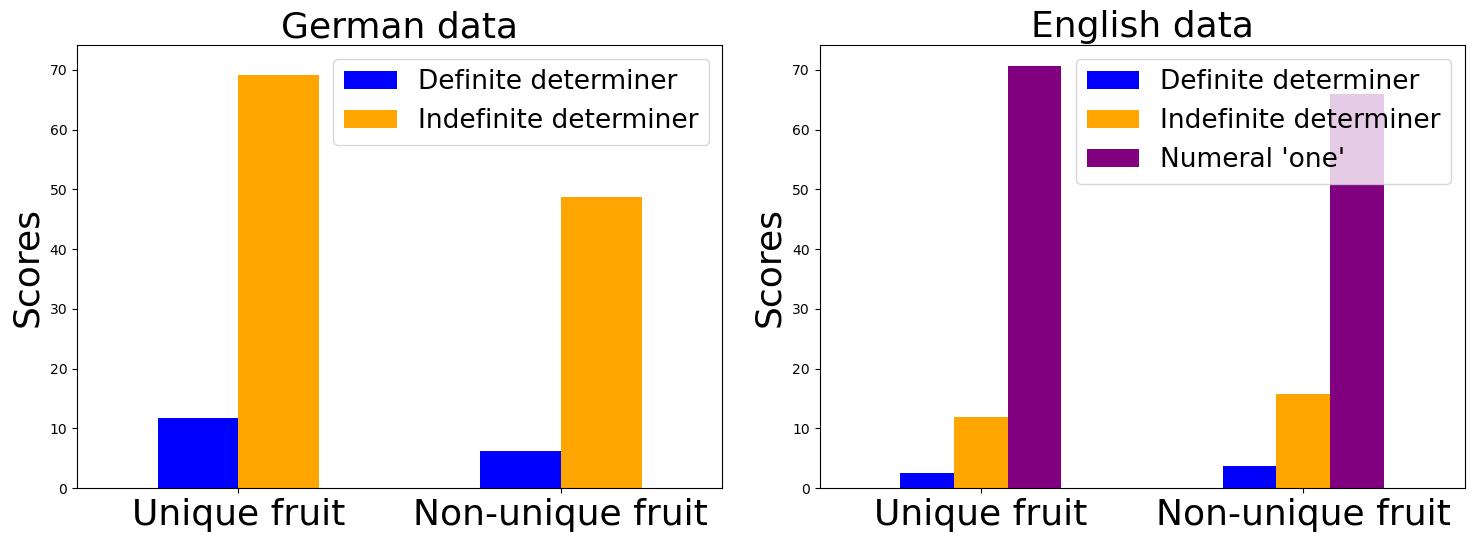

In [102]:
# Grouped data for GERMAN
grouped_data_german = all_models_results.groupby("sentence_type")[["score_def", "score_indef"]].mean()
# Grouped data for English
grouped_data_english = all_models_results_EN.groupby("sentence_type")[["score_def", "score_indef", "score_one"]].mean()

# Define custom colors for the columns ## hier noch gucken, was schön wäre 
german_colors = ["blue", "orange"]  
english_colors = ["blue", "orange", "purple"]  

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define custom labels for sentence types
custom_labels = ["Unique fruit", "Non-unique fruit"]

# Plot for German
grouped_data_german.plot(kind="bar", ax=ax1, color=german_colors)
ax1.set_title("German data", fontsize="26")
ax1.set_ylabel("Scores", fontsize="26")
ax1.set_xticklabels(custom_labels, rotation=0, fontsize="26")
ax1.set_xlabel("")
ax1.legend(["Definite determiner", "Indefinite determiner"], fontsize="19")

# Plot for English
grouped_data_english.plot(kind="bar", ax=ax2, color=english_colors)
ax2.set_title("English data", fontsize="26")
ax2.set_ylabel("Scores", fontsize="26")
ax2.set_xticklabels(custom_labels, rotation=0, fontsize="26")
ax2.set_xlabel("")
ax2.legend(["Definite determiner", "Indefinite determiner", "Numeral 'one'"], fontsize="19")

# Make the y-axis scales of the subplots the same
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add space for the suptitle
plt.show()


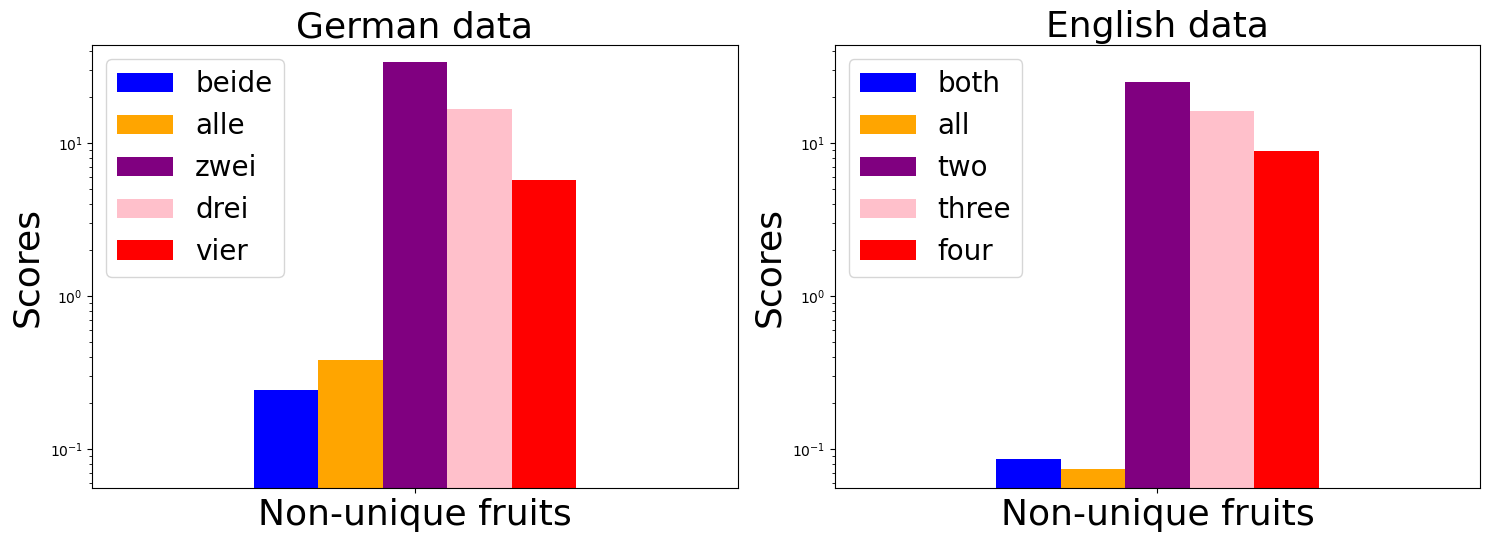

In [103]:
# Grouped data for GERMAN
grouped_data_german = all_models_results_allebeide.groupby("sentence_type")[["score_both", 
                                                                            "score_all", 
                                                                            "score_two", 
                                                                            "score_three",
                                                                            "score_four"]].mean()
# Grouped data for English
grouped_data_english = all_models_results_allboth.groupby("sentence_type")[["score_both", 
                                                                            "score_all", 
                                                                            "score_two", 
                                                                            "score_three",
                                                                            "score_four"]].mean()

# Define custom colors for the columns ## hier noch gucken, was schön wäre 
german_colors = ["blue", "orange", "purple", "pink", "red"]  
english_colors = ["blue", "orange", "purple", "pink", "red"]  

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define custom labels for sentence types
custom_labels = ["Non-unique fruits"]#, "Felicitous indefinite"]

# Plot for GERMAN
grouped_data_german.plot(kind="bar", ax=ax1, color=german_colors)
ax1.set_title("German data", fontsize="26")
ax1.set_ylabel("Scores", fontsize="26")
ax1.set_xticklabels(custom_labels, rotation=0, fontsize="26")
ax1.set_xlabel("")
ax1.legend(["beide", "alle","zwei", "drei", "vier"], fontsize="20")
ax1.set_yscale("log")


# Plot for English
grouped_data_english.plot(kind="bar", ax=ax2, color=english_colors)
ax2.set_title("English data", fontsize="26")
ax2.set_ylabel("Scores", fontsize="26")
ax2.set_xticklabels(custom_labels, rotation=0, fontsize="26")
ax2.set_xlabel("")
ax2.legend(["both", "all","two", "three", "four"], fontsize="20")
ax2.set_yscale("log")

# Make the y-axis scales of the subplots the same
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add space for the suptitle
plt.show()
